In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_19_23_23
NN-MODEL FILENAME:  ./models/VBKG0BIX_19_23_23_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 5000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1306.43 MiB, increment: 1085.77 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


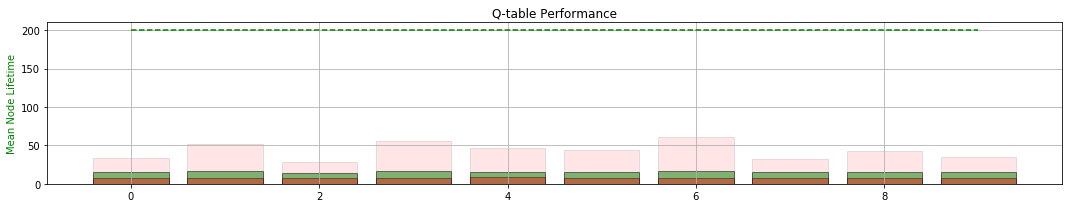

MEMORY COUNTER:  15558
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 624.241	LOSS : 600.516	
Validating... MEAN TIME:  9.34
LOSS : 635.032	LOSS : 588.245	
Validating... MEAN TIME:  49.9
LOSS : 610.574	LOSS : 573.134	
Validating... MEAN TIME:  32.725
LOSS : 594.320	LOSS : 550.615	
Validating... MEAN TIME:  21.48
LOSS : 542.194	LOSS : 550.035	
Validating... MEAN TIME:  18.12
TRAINING TIME:0:00:10.540804


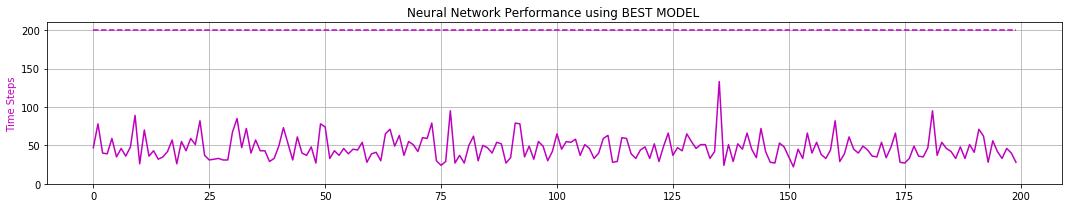

peak memory: 1336.72 MiB, increment: 1058.52 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   35938
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 165
TOTAL SERIAL TIMESTEPS:   51496
TOTAL PARALLEL TIME

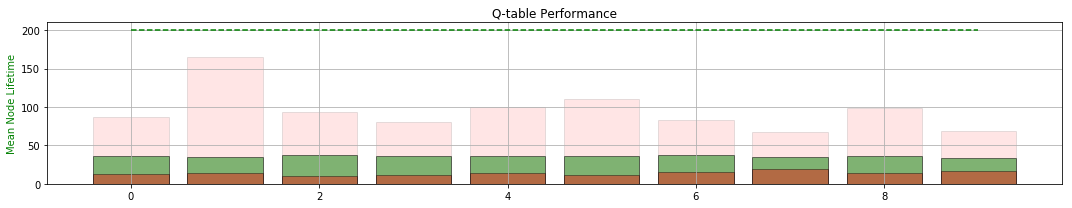

MEMORY COUNTER:  51496
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 345.173	LOSS : 372.873	
Validating... MEAN TIME:  9.395
LOSS : 347.741	LOSS : 367.974	
Validating... MEAN TIME:  9.27
LOSS : 351.243	LOSS : 364.611	
Validating... MEAN TIME:  9.425
LOSS : 367.918	LOSS : 325.356	
Validating... MEAN TIME:  9.4
LOSS : 370.971	LOSS : 337.882	
Validating... MEAN TIME:  9.34
TRAINING TIME:0:00:07.828146


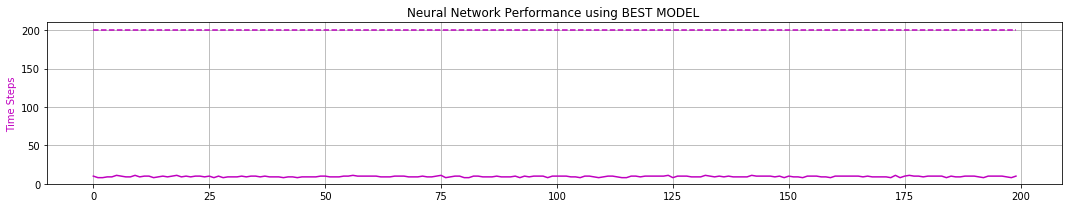

peak memory: 1365.39 MiB, increment: 1045.71 MiB
0 -max- [ 0.115  0.624  0.209  2.104]
0 -min- [-0.305 -1.389 -0.209 -1.535]

1 -max- [ 0.110  0.805  0.209  1.649]
1 -min- [-0.191 -0.952 -0.209 -1.437]

2 -max- [ 0.108  0.804  0.209  1.950]
2 -min- [-0.238 -1.170 -0.209 -1.382]

3 -max- [ 0.169  0.810  0.209  1.687]
3 -min- [-0.241 -1.027 -0.208 -1.588]

4 -max- [ 0.122  1.002  0.209  1.696]
4 -min- [-0.224 -1.020 -0.209 -1.742]

5 -max- [ 0.123  0.974  0.209  1.631]
5 -min- [-0.179 -0.979 -0.208 -1.556]

6 -max- [ 0.169  1.022  0.209  1.729]
6 -min- [-0.231 -1.179 -0.209 -1.757]

7 -max- [ 0.115  0.645  0.209  1.719]
7 -min- [-0.290 -0.947 -0.209 -1.356]

8 -max- [ 0.152  1.002  0.209  1.648]
8 -min- [-0.272 -0.835 -0.208 -1.505]

9 -max- [ 0.071  1.168  0.209  1.950]
9 -min- [-0.188 -1.173 -0.209 -1.924]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   10552
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 23
TOTAL SERIAL TIMESTEPS:   62048
TOTAL PARALLEL TIMEST

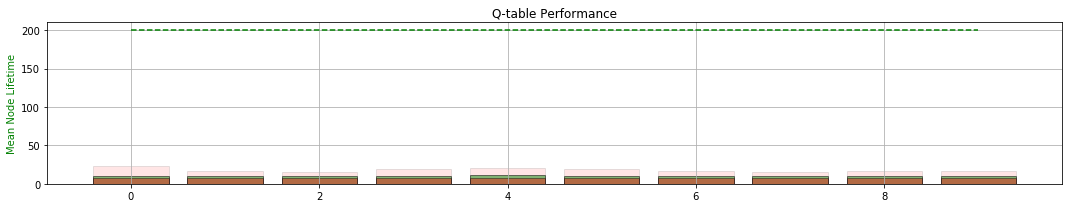

MEMORY COUNTER:  62048
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 421.973	LOSS : 473.838	
Validating... MEAN TIME:  12.195
LOSS : 467.478	LOSS : 439.804	
Validating... MEAN TIME:  19.46
LOSS : 416.211	LOSS : 422.827	
Validating... MEAN TIME:  27.875
LOSS : 407.013	LOSS : 430.122	
Validating... MEAN TIME:  57.705
LOSS : 436.008	LOSS : 437.155	
Validating... MEAN TIME:  66.825
TRAINING TIME:0:00:13.968202


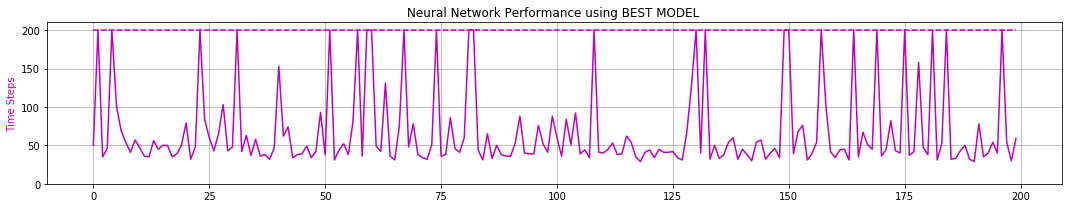

peak memory: 1428.83 MiB, increment: 1074.20 MiB
0 -max- [ 0.051  0.609  0.208  2.962]
0 -min- [-0.225 -1.930 -0.050 -0.848]

1 -max- [ 0.056  0.372  0.209  2.928]
1 -min- [-0.194 -1.922 -0.067 -0.646]

2 -max- [ 0.048  0.361  0.209  2.789]
2 -min- [-0.211 -1.807 -0.050 -0.554]

3 -max- [ 0.054  0.558  0.209  2.946]
3 -min- [-0.211 -1.971 -0.092 -0.952]

4 -max- [ 0.050  0.423  0.209  2.948]
4 -min- [-0.203 -1.988 -0.083 -0.571]

5 -max- [ 0.054  0.241  0.209  2.950]
5 -min- [-0.205 -1.991 -0.050 -0.385]

6 -max- [ 0.053  0.433  0.209  2.949]
6 -min- [-0.226 -1.907 -0.050 -0.598]

7 -max- [ 0.056  0.377  0.209  2.963]
7 -min- [-0.204 -1.996 -0.056 -0.581]

8 -max- [ 0.050  0.353  0.209  2.941]
8 -min- [-0.218 -1.954 -0.048 -0.527]

9 -max- [ 0.050  0.222  0.209  2.967]
9 -min- [-0.216 -1.924 -0.047 -0.327]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   49646
SMALLEST TIMESTEP: 24
LARGEST  TIMESTEP: 146
TOTAL SERIAL TIMESTEPS:   111694
TOTAL PARALLEL TIM

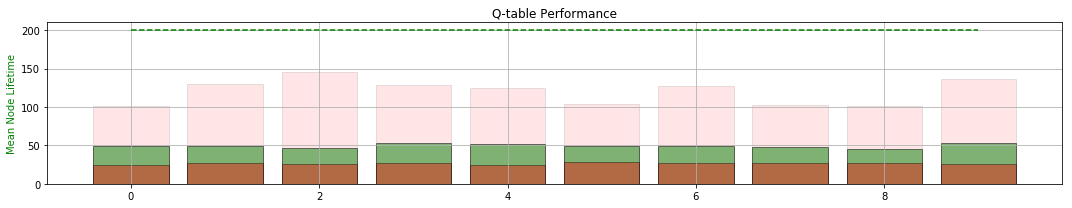

MEMORY COUNTER:  111694
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 337.242	LOSS : 303.238	
Validating... MEAN TIME:  59.79
LOSS : 323.305	LOSS : 314.928	
Validating... MEAN TIME:  112.42
LOSS : 333.077	LOSS : 324.375	
Validating... MEAN TIME:  148.18
LOSS : 317.979	LOSS : 317.066	
Validating... MEAN TIME:  131.325
LOSS : 323.721	LOSS : 293.795	
Validating... MEAN TIME:  104.65
TRAINING TIME:0:00:28.665644


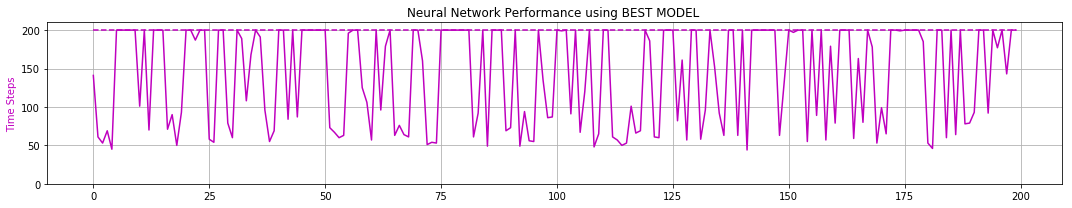

peak memory: 1429.88 MiB, increment: 1035.02 MiB
0 -max- [ 0.086  0.521  0.209  1.185]
0 -min- [-0.515 -0.921 -0.208 -0.842]

1 -max- [ 0.073  0.512  0.209  0.947]
1 -min- [-0.521 -1.063 -0.209 -0.766]

2 -max- [ 0.087  0.411  0.209  0.964]
2 -min- [-0.479 -0.908 -0.207 -0.787]

3 -max- [ 0.082  0.401  0.209  1.064]
3 -min- [-0.520 -0.897 -0.209 -0.804]

4 -max- [ 0.079  0.491  0.209  1.119]
4 -min- [-0.484 -0.893 -0.209 -1.081]

5 -max- [ 0.072  0.420  0.209  1.081]
5 -min- [-0.480 -0.885 -0.209 -0.801]

6 -max- [ 0.085  0.503  0.209  1.190]
6 -min- [-0.517 -0.899 -0.209 -0.803]

7 -max- [ 0.076  0.495  0.209  1.201]
7 -min- [-0.501 -0.913 -0.209 -0.795]

8 -max- [ 0.087  0.502  0.209  1.015]
8 -min- [-0.470 -0.778 -0.209 -0.998]

9 -max- [ 0.082  0.508  0.209  0.930]
9 -min- [-0.505 -0.905 -0.209 -1.025]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   68978
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 154
TOTAL SERIAL TIMESTEPS:   180672
TOTAL PARALLEL TIM

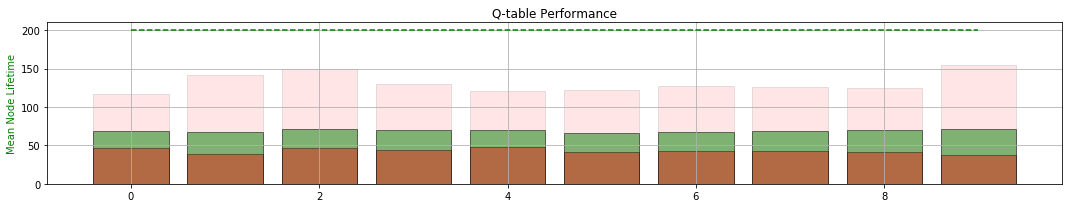

MEMORY COUNTER:  180672
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 242.205	LOSS : 258.664	
Validating... MEAN TIME:  96.19
LOSS : 252.735	LOSS : 257.910	
Validating... MEAN TIME:  95.66
LOSS : 252.241	LOSS : 264.425	
Validating... MEAN TIME:  107.435
LOSS : 245.276	LOSS : 247.109	
Validating... MEAN TIME:  104.825
LOSS : 250.820	LOSS : 255.117	
Validating... MEAN TIME:  90.3
TRAINING TIME:0:00:25.494609


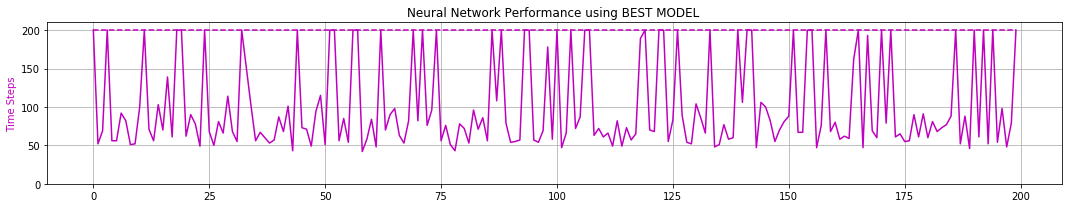

peak memory: 1395.33 MiB, increment: 1017.73 MiB
0 -max- [ 0.204  0.768  0.209  1.039]
0 -min- [-0.343 -0.770 -0.209 -0.890]

1 -max- [ 0.216  0.761  0.209  1.087]
1 -min- [-0.317 -0.771 -0.208 -0.951]

2 -max- [ 0.201  0.729  0.209  1.093]
2 -min- [-0.327 -0.767 -0.209 -0.781]

3 -max- [ 0.231  0.756  0.209  1.021]
3 -min- [-0.327 -0.897 -0.209 -1.031]

4 -max- [ 0.186  0.709  0.209  0.815]
4 -min- [-0.280 -0.741 -0.209 -0.900]

5 -max- [ 0.189  0.712  0.209  0.984]
5 -min- [-0.301 -0.806 -0.208 -1.056]

6 -max- [ 0.223  0.750  0.209  1.000]
6 -min- [-0.293 -0.772 -0.209 -0.786]

7 -max- [ 0.212  0.719  0.209  1.090]
7 -min- [-0.266 -0.762 -0.208 -0.794]

8 -max- [ 0.200  0.768  0.209  1.102]
8 -min- [-0.292 -0.768 -0.208 -0.866]

9 -max- [ 0.199  0.750  0.209  0.854]
9 -min- [-0.294 -0.777 -0.209 -0.796]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   57369
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 180
TOTAL SERIAL TIMESTEPS:   238041
TOTAL PARALLEL TIM

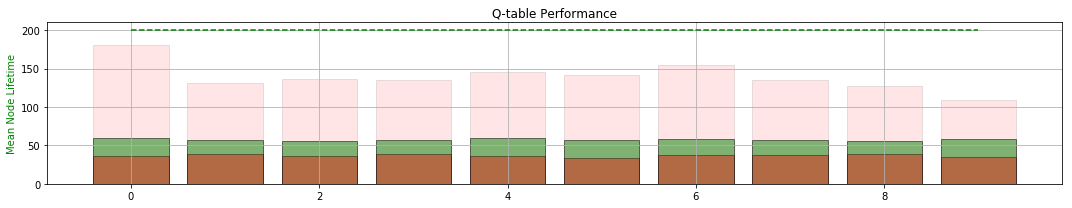

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 209.988	LOSS : 215.493	
Validating... MEAN TIME:  110.97
LOSS : 212.112	LOSS : 174.022	
Validating... MEAN TIME:  123.065
LOSS : 220.072	LOSS : 212.247	
Validating... MEAN TIME:  128.775
LOSS : 197.792	LOSS : 211.376	
Validating... MEAN TIME:  139.67
LOSS : 197.451	LOSS : 194.908	
Validating... MEAN TIME:  148.09
TRAINING TIME:0:00:30.853932


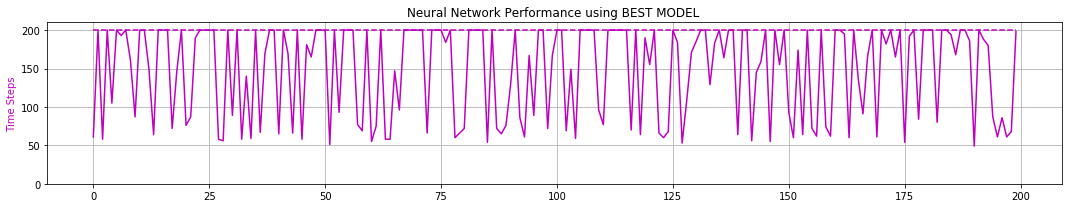

peak memory: 1408.61 MiB, increment: 1031.40 MiB
0 -max- [ 0.368  0.758  0.209  1.097]
0 -min- [-0.214 -0.768 -0.209 -0.951]

1 -max- [ 0.370  0.727  0.209  0.807]
1 -min- [-0.223 -0.769 -0.209 -0.980]

2 -max- [ 0.341  0.735  0.209  0.786]
2 -min- [-0.217 -0.765 -0.209 -1.015]

3 -max- [ 0.362  0.741  0.209  0.789]
3 -min- [-0.220 -0.751 -0.209 -0.870]

4 -max- [ 0.364  0.730  0.209  0.833]
4 -min- [-0.209 -0.776 -0.209 -1.128]

5 -max- [ 0.375  0.741  0.209  0.808]
5 -min- [-0.210 -0.768 -0.209 -0.940]

6 -max- [ 0.364  0.717  0.209  0.838]
6 -min- [-0.200 -0.774 -0.209 -0.937]

7 -max- [ 0.352  0.731  0.208  0.801]
7 -min- [-0.231 -0.766 -0.209 -1.061]

8 -max- [ 0.351  0.739  0.209  0.805]
8 -min- [-0.212 -0.720 -0.209 -0.808]

9 -max- [ 0.342  0.715  0.209  0.824]
9 -min- [-0.239 -0.765 -0.209 -0.986]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   92057
SMALLEST TIMESTEP: 41
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   330098
TOTAL PARALLEL TIM

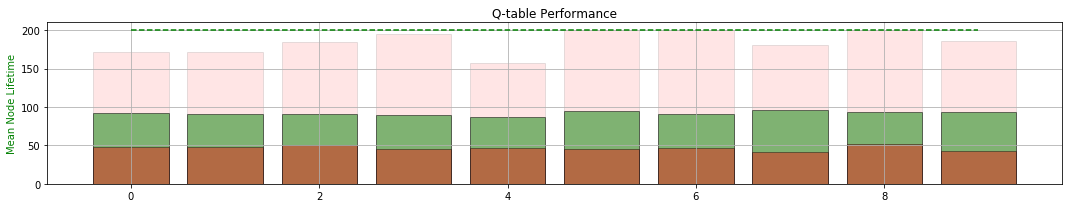

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 138.499	LOSS : 143.860	
Validating... MEAN TIME:  145.97
LOSS : 140.874	LOSS : 128.825	
Validating... MEAN TIME:  134.42
LOSS : 122.669	LOSS : 144.493	
Validating... MEAN TIME:  135.425
LOSS : 114.859	LOSS : 130.505	
Validating... MEAN TIME:  147.655
LOSS : 124.150	LOSS : 132.937	
Validating... MEAN TIME:  149.71
TRAINING TIME:0:00:32.970357


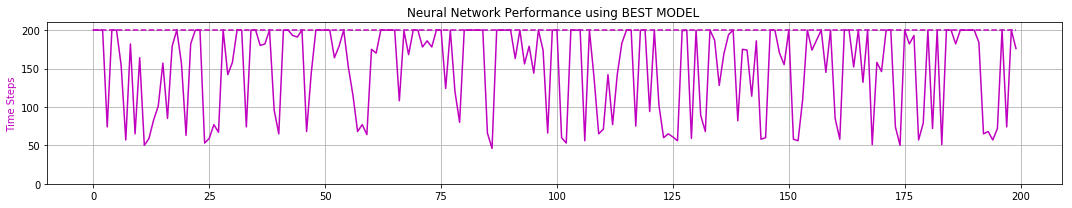

peak memory: 1451.61 MiB, increment: 978.67 MiB
0 -max- [ 0.247  0.761  0.209  0.853]
0 -min- [-0.293 -0.911 -0.209 -0.813]

1 -max- [ 0.251  0.761  0.208  1.042]
1 -min- [-0.308 -0.884 -0.209 -1.007]

2 -max- [ 0.256  0.726  0.209  0.902]
2 -min- [-0.280 -0.778 -0.209 -0.799]

3 -max- [ 0.260  0.696  0.209  1.039]
3 -min- [-0.313 -0.773 -0.209 -0.853]

4 -max- [ 0.259  0.763  0.209  0.847]
4 -min- [-0.272 -0.776 -0.209 -0.846]

5 -max- [ 0.253  0.741  0.209  1.079]
5 -min- [-0.299 -0.771 -0.209 -0.875]

6 -max- [ 0.243  0.891  0.209  1.043]
6 -min- [-0.272 -0.767 -0.209 -0.800]

7 -max- [ 0.259  0.751  0.209  0.875]
7 -min- [-0.277 -0.777 -0.207 -0.796]

8 -max- [ 0.255  0.920  0.209  1.039]
8 -min- [-0.342 -0.775 -0.209 -1.097]

9 -max- [ 0.297  0.758  0.209  1.057]
9 -min- [-0.288 -0.707 -0.209 -0.997]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   89838
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   419936
TOTAL PARALLEL TIME

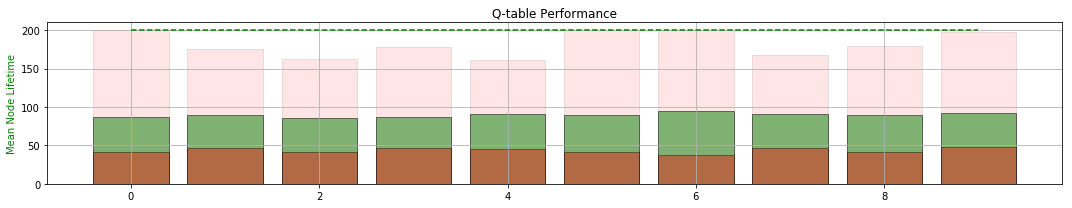

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 119.259	LOSS : 121.379	
Validating... MEAN TIME:  145.9
LOSS : 107.365	LOSS : 105.424	
Validating... MEAN TIME:  141.63
LOSS : 114.525	LOSS : 110.566	
Validating... MEAN TIME:  140.78
LOSS : 130.267	LOSS : 111.010	
Validating... MEAN TIME:  139.765
LOSS : 120.183	LOSS : 117.932	
Validating... MEAN TIME:  141.355
TRAINING TIME:0:00:33.917139


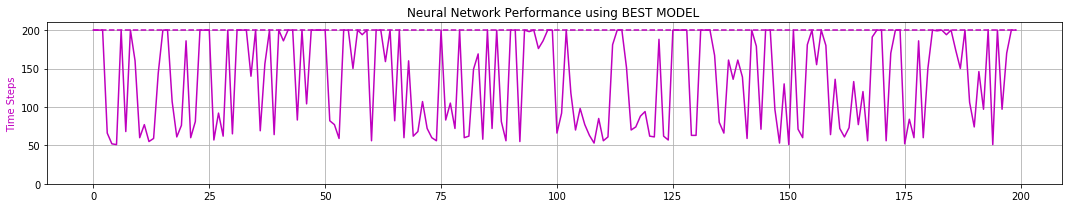

peak memory: 1454.54 MiB, increment: 1017.60 MiB
0 -max- [ 0.198  0.733  0.209  1.078]
0 -min- [-0.319 -0.958 -0.209 -0.910]

1 -max- [ 0.226  0.769  0.209  1.055]
1 -min- [-0.301 -0.767 -0.208 -1.008]

2 -max- [ 0.222  0.580  0.209  1.001]
2 -min- [-0.299 -0.772 -0.208 -0.875]

3 -max- [ 0.211  0.752  0.209  1.022]
3 -min- [-0.321 -0.768 -0.209 -1.036]

4 -max- [ 0.293  0.599  0.209  0.877]
4 -min- [-0.299 -0.769 -0.209 -0.856]

5 -max- [ 0.220  0.738  0.209  0.893]
5 -min- [-0.282 -0.772 -0.209 -0.812]

6 -max- [ 0.204  0.699  0.209  1.096]
6 -min- [-0.294 -0.778 -0.208 -0.796]

7 -max- [ 0.221  0.768  0.209  1.110]
7 -min- [-0.283 -0.774 -0.209 -0.900]

8 -max- [ 0.203  0.751  0.209  0.970]
8 -min- [-0.291 -0.727 -0.209 -0.803]

9 -max- [ 0.218  0.715  0.209  1.010]
9 -min- [-0.303 -0.778 -0.209 -1.062]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   67998
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 150
TOTAL SERIAL TIMESTEPS:   487934
TOTAL PARALLEL TIM

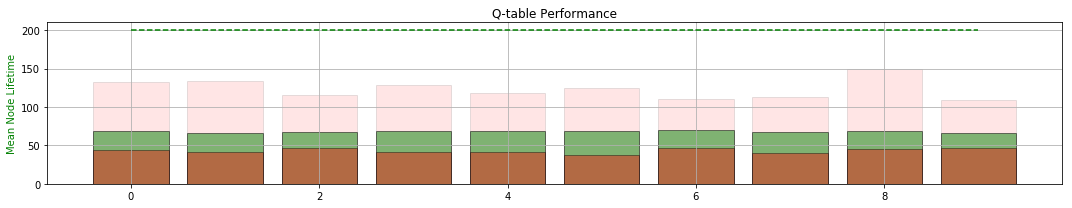

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 133.519	LOSS : 126.092	
Validating... MEAN TIME:  143.38
LOSS : 132.172	LOSS : 125.663	
Validating... MEAN TIME:  144.725
LOSS : 110.770	LOSS : 125.644	
Validating... MEAN TIME:  142.37
LOSS : 117.470	LOSS : 125.659	
Validating... MEAN TIME:  136.255
LOSS : 110.677	LOSS : 127.291	
Validating... MEAN TIME:  149.74
TRAINING TIME:0:00:33.113804


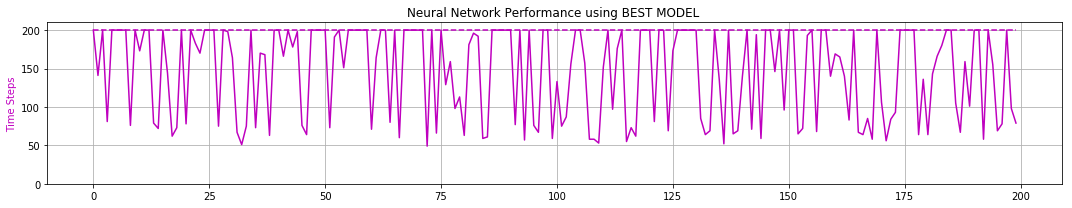

peak memory: 1445.84 MiB, increment: 1036.45 MiB
0 -max- [ 0.182  0.763  0.209  1.043]
0 -min- [-0.301 -0.871 -0.209 -0.775]

1 -max- [ 0.174  0.721  0.209  0.989]
1 -min- [-0.287 -0.775 -0.209 -1.054]

2 -max- [ 0.183  0.740  0.209  1.013]
2 -min- [-0.278 -0.767 -0.209 -0.803]

3 -max- [ 0.195  0.577  0.209  0.810]
3 -min- [-0.299 -0.778 -0.209 -0.767]

4 -max- [ 0.190  0.937  0.209  0.919]
4 -min- [-0.296 -0.773 -0.208 -0.866]

5 -max- [ 0.172  0.676  0.209  0.997]
5 -min- [-0.294 -0.781 -0.208 -0.800]

6 -max- [ 0.209  0.708  0.209  1.141]
6 -min- [-0.276 -0.768 -0.207 -0.769]

7 -max- [ 0.171  0.679  0.209  0.849]
7 -min- [-0.307 -0.743 -0.209 -0.923]

8 -max- [ 0.189  0.577  0.209  0.997]
8 -min- [-0.274 -0.778 -0.209 -0.798]

9 -max- [ 0.177  0.705  0.209  1.117]
9 -min- [-0.300 -0.781 -0.209 -0.770]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   90487
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   578421
TOTAL PARALLEL TIM

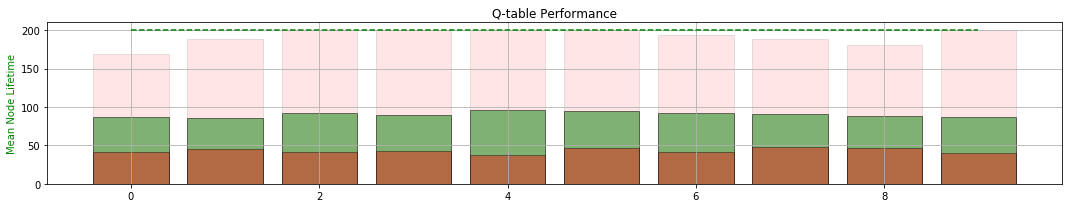

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 136.028	LOSS : 122.255	
Validating... MEAN TIME:  138.63
LOSS : 111.565	LOSS : 121.580	
Validating... MEAN TIME:  140.625
LOSS : 112.807	LOSS : 114.695	
Validating... MEAN TIME:  141.365
LOSS : 118.084	LOSS : 138.176	
Validating... MEAN TIME:  132.455
LOSS : 127.884	LOSS : 132.051	
Validating... MEAN TIME:  156.54
TRAINING TIME:0:00:32.366164


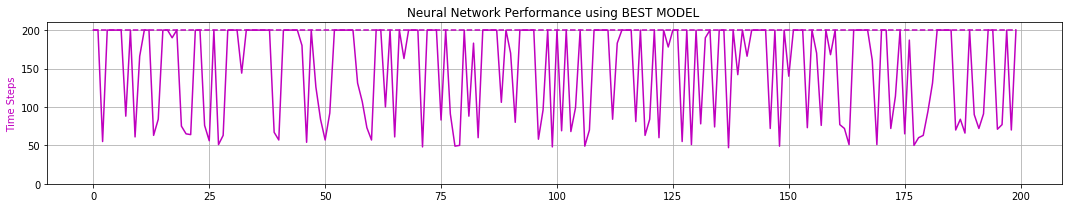

peak memory: 1464.89 MiB, increment: 996.90 MiB
0 -max- [ 0.224  0.731  0.209  1.019]
0 -min- [-0.381 -0.887 -0.209 -0.773]

1 -max- [ 0.214  0.766  0.209  1.109]
1 -min- [-0.374 -0.953 -0.209 -0.772]

2 -max- [ 0.224  0.576  0.209  0.942]
2 -min- [-0.381 -0.887 -0.209 -0.742]

3 -max- [ 0.194  0.685  0.209  1.080]
3 -min- [-0.364 -0.923 -0.209 -0.981]

4 -max- [ 0.215  0.680  0.209  1.100]
4 -min- [-0.361 -0.903 -0.209 -0.865]

5 -max- [ 0.223  0.575  0.209  0.958]
5 -min- [-0.350 -1.073 -0.208 -0.779]

6 -max- [ 0.210  0.685  0.209  0.970]
6 -min- [-0.353 -0.928 -0.209 -0.762]

7 -max- [ 0.235  0.689  0.209  1.051]
7 -min- [-0.352 -0.904 -0.209 -0.767]

8 -max- [ 0.222  0.716  0.209  1.008]
8 -min- [-0.364 -0.880 -0.209 -0.884]

9 -max- [ 0.221  0.758  0.209  1.162]
9 -min- [-0.375 -0.904 -0.209 -0.792]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   101431
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   679852
TOTAL PARALLEL TI

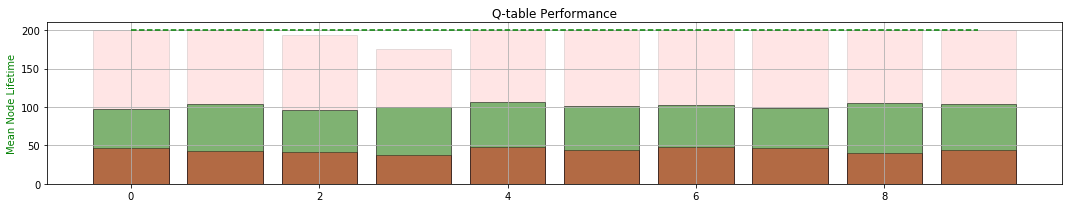

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 91.595	LOSS : 98.069	
Validating... MEAN TIME:  141.99
LOSS : 89.260	LOSS : 105.854	
Validating... MEAN TIME:  151.8
LOSS : 110.992	LOSS : 100.744	
Validating... MEAN TIME:  159.715
LOSS : 95.203	LOSS : 103.927	
Validating... MEAN TIME:  152.675
LOSS : 107.356	LOSS : 108.560	
Validating... MEAN TIME:  158.475
TRAINING TIME:0:00:35.038451


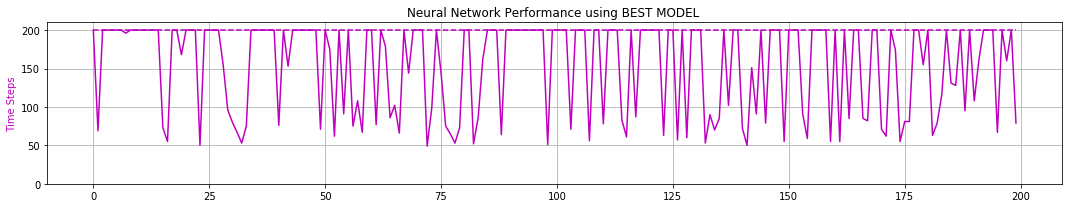

peak memory: 1482.22 MiB, increment: 1032.87 MiB
0 -max- [ 0.194  0.574  0.209  1.174]
0 -min- [-0.532 -1.269 -0.209 -0.863]

1 -max- [ 0.208  0.725  0.209  0.767]
1 -min- [-0.481 -1.106 -0.209 -0.889]

2 -max- [ 0.223  0.735  0.208  0.825]
2 -min- [-0.481 -1.263 -0.209 -0.898]

3 -max- [ 0.196  0.575  0.209  0.890]
3 -min- [-0.488 -1.089 -0.209 -0.828]

4 -max- [ 0.204  0.575  0.208  0.868]
4 -min- [-0.489 -1.246 -0.209 -0.995]

5 -max- [ 0.201  0.585  0.209  0.805]
5 -min- [-0.479 -1.109 -0.209 -0.824]

6 -max- [ 0.183  0.575  0.209  0.880]
6 -min- [-0.483 -1.132 -0.209 -0.825]

7 -max- [ 0.201  0.761  0.209  0.939]
7 -min- [-0.486 -1.256 -0.209 -0.739]

8 -max- [ 0.202  0.574  0.209  0.872]
8 -min- [-0.459 -1.271 -0.209 -0.897]

9 -max- [ 0.216  0.762  0.209  0.965]
9 -min- [-0.508 -1.146 -0.209 -0.824]

Quantization TIME:  0.02 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   79825
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 166
TOTAL SERIAL TIMESTEPS:   759677
TOTAL PARALLEL TI

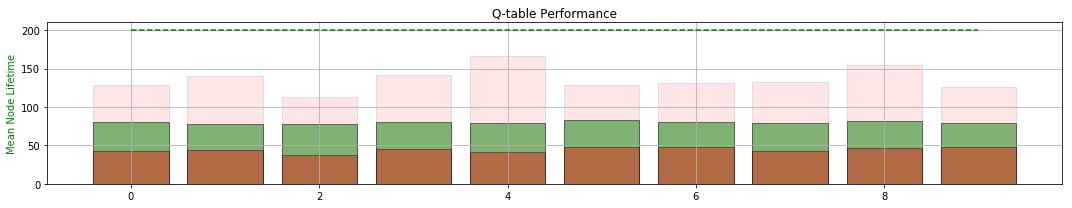

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 100.307	LOSS : 109.737	
Validating... MEAN TIME:  154.295
LOSS : 111.628	LOSS : 101.477	
Validating... MEAN TIME:  159.51
LOSS : 109.777	LOSS : 108.567	
Validating... MEAN TIME:  158.5
LOSS : 112.820	LOSS : 100.798	
Validating... MEAN TIME:  149.23
LOSS : 105.544	LOSS : 102.307	
Validating... MEAN TIME:  143.805
TRAINING TIME:0:00:35.473419


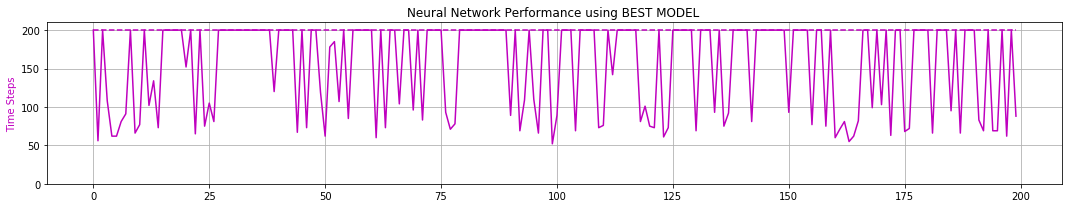

peak memory: 1463.32 MiB, increment: 1027.00 MiB
0 -max- [ 0.218  0.576  0.209  0.966]
0 -min- [-0.493 -1.260 -0.209 -0.710]

1 -max- [ 0.214  0.702  0.208  0.873]
1 -min- [-0.511 -1.285 -0.209 -1.081]

2 -max- [ 0.226  0.573  0.208  0.770]
2 -min- [-0.481 -1.259 -0.209 -0.807]

3 -max- [ 0.231  0.575  0.209  0.920]
3 -min- [-0.502 -1.241 -0.209 -0.944]

4 -max- [ 0.210  0.677  0.209  0.793]
4 -min- [-0.500 -1.266 -0.209 -1.003]

5 -max- [ 0.216  0.582  0.209  0.912]
5 -min- [-0.474 -1.274 -0.209 -0.818]

6 -max- [ 0.202  0.575  0.209  0.834]
6 -min- [-0.483 -1.422 -0.209 -0.972]

7 -max- [ 0.210  0.574  0.209  0.896]
7 -min- [-0.505 -1.298 -0.209 -0.807]

8 -max- [ 0.208  0.716  0.209  0.915]
8 -min- [-0.508 -1.269 -0.209 -0.825]

9 -max- [ 0.251  0.576  0.209  0.985]
9 -min- [-0.487 -1.269 -0.209 -0.837]

Quantization TIME:  0.02 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   67618
SMALLEST TIMESTEP: 41
LARGEST  TIMESTEP: 158
TOTAL SERIAL TIMESTEPS:   827295
TOTAL PARALLEL TI

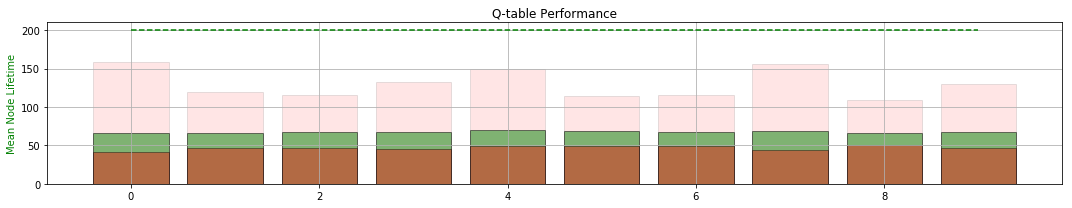

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 112.219	LOSS : 126.975	
Validating... MEAN TIME:  133.67
LOSS : 117.046	LOSS : 132.302	
Validating... MEAN TIME:  111.53
LOSS : 111.238	LOSS : 109.081	
Validating... MEAN TIME:  118.08
LOSS : 126.174	LOSS : 120.376	
Validating... MEAN TIME:  119.205
LOSS : 117.572	LOSS : 120.780	
Validating... MEAN TIME:  112.52
TRAINING TIME:0:00:28.937006


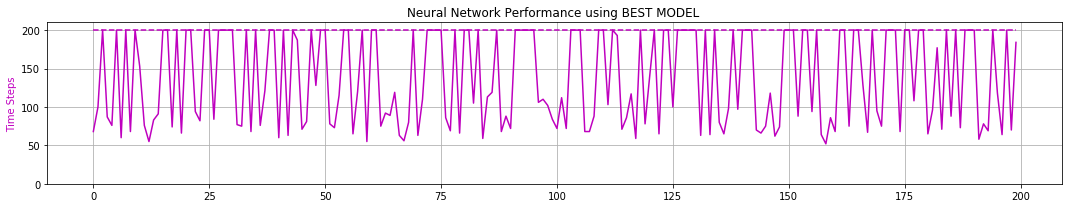

peak memory: 1441.01 MiB, increment: 1036.50 MiB
0 -max- [ 0.296  0.698  0.209  0.833]
0 -min- [-0.501 -1.321 -0.209 -0.819]

1 -max- [ 0.302  0.574  0.209  0.884]
1 -min- [-0.485 -1.231 -0.209 -0.788]

2 -max- [ 0.302  0.615  0.209  0.834]
2 -min- [-0.468 -1.302 -0.209 -1.106]

3 -max- [ 0.295  0.736  0.209  0.905]
3 -min- [-0.477 -1.327 -0.209 -0.806]

4 -max- [ 0.316  0.712  0.209  1.031]
4 -min- [-0.458 -1.295 -0.209 -0.988]

5 -max- [ 0.296  0.722  0.209  0.877]
5 -min- [-0.433 -1.268 -0.209 -0.805]

6 -max- [ 0.300  0.594  0.209  0.839]
6 -min- [-0.450 -1.286 -0.209 -0.810]

7 -max- [ 0.313  0.761  0.208  0.838]
7 -min- [-0.451 -1.306 -0.209 -0.839]

8 -max- [ 0.292  0.722  0.208  0.840]
8 -min- [-0.479 -1.307 -0.209 -0.803]

9 -max- [ 0.298  0.582  0.209  0.940]
9 -min- [-0.468 -1.311 -0.209 -0.762]

Quantization TIME:  0.01 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   62373
SMALLEST TIMESTEP: 37
LARGEST  TIMESTEP: 195
TOTAL SERIAL TIMESTEPS:   889668
TOTAL PARALLEL TI

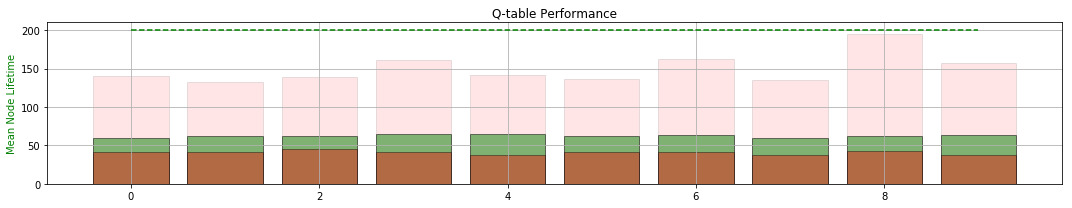

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 137.281	LOSS : 116.419	
Validating... MEAN TIME:  109.42
LOSS : 137.313	LOSS : 141.539	
Validating... MEAN TIME:  103.655
LOSS : 118.884	LOSS : 121.497	
Validating... MEAN TIME:  100.605
LOSS : 144.541	LOSS : 138.655	
Validating... MEAN TIME:  94.345
LOSS : 125.567	LOSS : 132.993	
Validating... MEAN TIME:  83.185
TRAINING TIME:0:00:25.015483


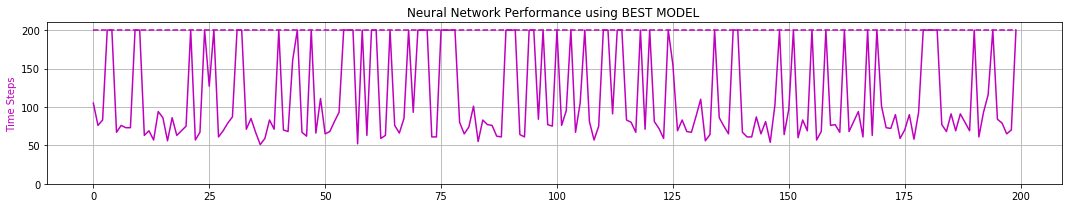

peak memory: 1469.15 MiB, increment: 1005.92 MiB
0 -max- [ 0.297  0.582  0.209  0.884]
0 -min- [-0.343 -1.088 -0.209 -0.743]

1 -max- [ 0.381  0.720  0.209  0.997]
1 -min- [-0.362 -1.147 -0.209 -1.026]

2 -max- [ 0.297  0.668  0.209  0.837]
2 -min- [-0.354 -1.085 -0.209 -0.838]

3 -max- [ 0.318  0.710  0.208  0.882]
3 -min- [-0.329 -1.125 -0.209 -0.798]

4 -max- [ 0.287  0.712  0.208  0.851]
4 -min- [-0.352 -1.251 -0.209 -0.906]

5 -max- [ 0.345  0.701  0.209  0.965]
5 -min- [-0.373 -1.118 -0.209 -0.820]

6 -max- [ 0.284  0.702  0.208  1.073]
6 -min- [-0.332 -1.088 -0.209 -0.837]

7 -max- [ 0.303  0.745  0.209  0.827]
7 -min- [-0.377 -1.086 -0.209 -0.809]

8 -max- [ 0.307  0.717  0.209  1.098]
8 -min- [-0.344 -1.088 -0.209 -0.823]

9 -max- [ 0.346  0.736  0.209  0.860]
9 -min- [-0.343 -1.080 -0.209 -0.787]

Quantization TIME:  0.02 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   58045
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 139
TOTAL SERIAL TIMESTEPS:   947713
TOTAL PARALLEL TI

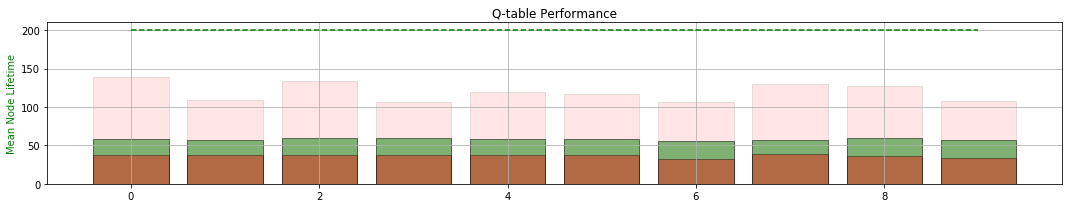

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 143.562	LOSS : 139.956	
Validating... MEAN TIME:  83.82
LOSS : 144.706	LOSS : 146.646	
Validating... MEAN TIME:  89.325
LOSS : 144.205	LOSS : 138.399	
Validating... MEAN TIME:  85.11
LOSS : 143.577	LOSS : 143.364	
Validating... MEAN TIME:  84.135
LOSS : 143.644	LOSS : 134.809	
Validating... MEAN TIME:  91.81
TRAINING TIME:0:00:22.120260


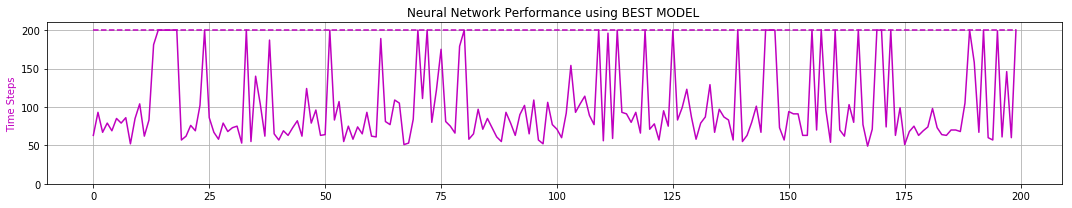

peak memory: 1474.02 MiB, increment: 1010.65 MiB
0 -max- [ 0.391  0.727  0.208  0.870]
0 -min- [-0.301 -0.935 -0.209 -1.114]

1 -max- [ 0.309  0.890  0.209  0.837]
1 -min- [-0.254 -0.919 -0.209 -0.829]

2 -max- [ 0.360  0.728  0.209  0.802]
2 -min- [-0.274 -0.945 -0.209 -0.821]

3 -max- [ 0.339  0.722  0.209  0.802]
3 -min- [-0.298 -0.939 -0.209 -0.989]

4 -max- [ 0.368  0.724  0.209  1.011]
4 -min- [-0.239 -0.952 -0.209 -0.773]

5 -max- [ 0.289  0.724  0.209  0.801]
5 -min- [-0.258 -0.958 -0.209 -0.816]

6 -max- [ 0.357  0.722  0.209  0.891]
6 -min- [-0.320 -0.941 -0.209 -0.780]

7 -max- [ 0.341  0.733  0.209  0.787]
7 -min- [-0.304 -0.921 -0.209 -0.846]

8 -max- [ 0.326  0.721  0.209  0.965]
8 -min- [-0.265 -0.927 -0.209 -0.807]

9 -max- [ 0.316  0.679  0.209  0.834]
9 -min- [-0.252 -1.078 -0.209 -0.873]

Quantization TIME:  0.02 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   57108
SMALLEST TIMESTEP: 36
LARGEST  TIMESTEP: 129
TOTAL SERIAL TIMESTEPS:   1004821
TOTAL PARALLEL T

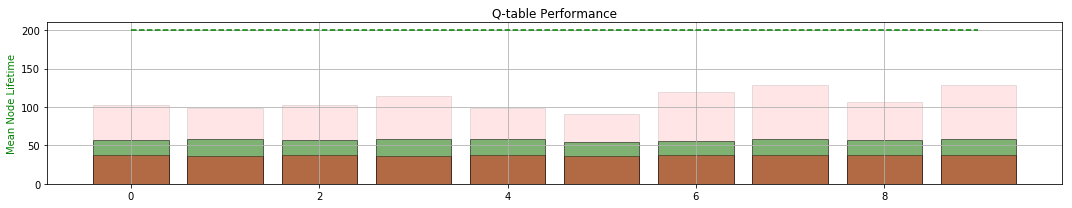

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 156.666	LOSS : 149.553	
Validating... MEAN TIME:  88.555
LOSS : 155.029	LOSS : 162.798	
Validating... MEAN TIME:  92.835
LOSS : 145.674	LOSS : 155.150	
Validating... MEAN TIME:  96.965
LOSS : 176.932	LOSS : 157.156	
Validating... MEAN TIME:  96.855
LOSS : 157.970	LOSS : 167.093	
Validating... MEAN TIME:  86.5
TRAINING TIME:0:00:23.514783


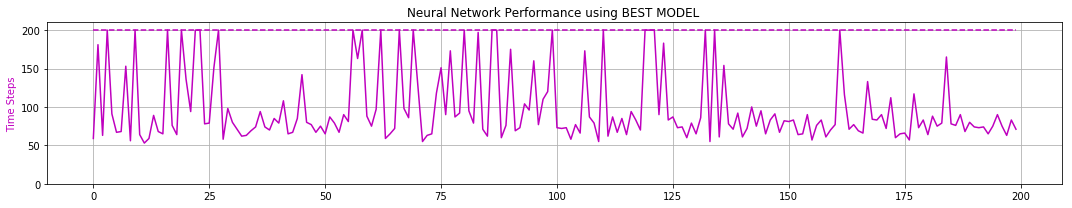

peak memory: 1480.09 MiB, increment: 977.52 MiB
0 -max- [ 0.316  0.757  0.209  1.035]
0 -min- [-0.281 -0.956 -0.209 -0.969]

1 -max- [ 0.298  0.732  0.209  0.857]
1 -min- [-0.319 -0.938 -0.209 -0.862]

2 -max- [ 0.309  0.715  0.209  0.881]
2 -min- [-0.290 -1.071 -0.209 -0.889]

3 -max- [ 0.368  0.730  0.209  0.803]
3 -min- [-0.277 -0.958 -0.209 -0.799]

4 -max- [ 0.314  0.728  0.209  0.987]
4 -min- [-0.261 -0.899 -0.209 -0.797]

5 -max- [ 0.282  0.723  0.209  0.827]
5 -min- [-0.265 -0.930 -0.209 -0.819]

6 -max- [ 0.265  0.715  0.208  0.787]
6 -min- [-0.264 -0.938 -0.209 -0.883]

7 -max- [ 0.318  0.722  0.209  0.799]
7 -min- [-0.275 -0.932 -0.209 -0.802]

8 -max- [ 0.327  0.756  0.209  0.826]
8 -min- [-0.266 -1.072 -0.209 -0.809]

9 -max- [ 0.467  0.669  0.209  0.807]
9 -min- [-0.263 -0.969 -0.209 -0.868]

Quantization TIME:  0.02 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   59163
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 161
TOTAL SERIAL TIMESTEPS:   1063984
TOTAL PARALLEL TI

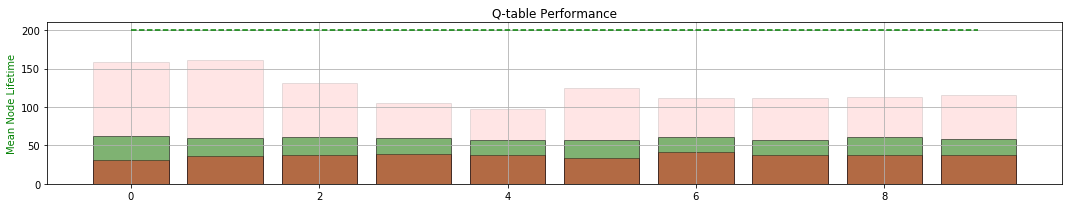

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 158.964	LOSS : 171.643	
Validating... MEAN TIME:  86.62
LOSS : 159.312	LOSS : 155.290	
Validating... MEAN TIME:  96.66
LOSS : 148.019	LOSS : 165.258	
Validating... MEAN TIME:  96.51
LOSS : 155.171	LOSS : 153.140	
Validating... MEAN TIME:  98.095
LOSS : 174.047	LOSS : 159.190	
Validating... MEAN TIME:  96.245
TRAINING TIME:0:00:24.457566


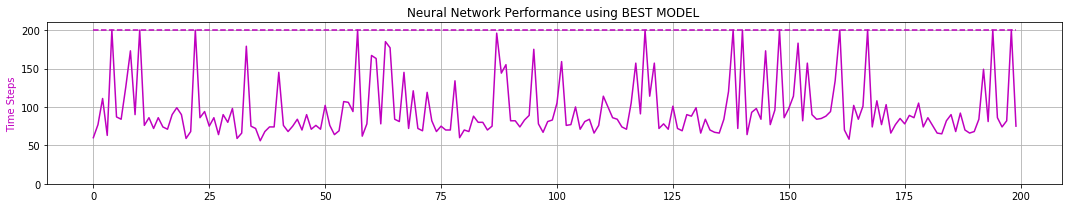

peak memory: 1458.37 MiB, increment: 1015.58 MiB
0 -max- [ 0.308  0.679  0.209  0.915]
0 -min- [-0.276 -1.087 -0.209 -1.076]

1 -max- [ 0.309  0.720  0.207  0.961]
1 -min- [-0.268 -1.149 -0.209 -1.022]

2 -max- [ 0.368  0.728  0.206  0.803]
2 -min- [-0.269 -1.124 -0.209 -0.783]

3 -max- [ 0.309  0.706  0.209  0.797]
3 -min- [-0.263 -1.089 -0.209 -0.806]

4 -max- [ 0.338  0.753  0.209  1.345]
4 -min- [-0.267 -1.139 -0.209 -0.817]

5 -max- [ 0.341  0.733  0.209  0.800]
5 -min- [-0.283 -1.085 -0.209 -0.795]

6 -max- [ 0.326  0.768  0.209  0.791]
6 -min- [-0.289 -1.257 -0.209 -0.783]

7 -max- [ 0.335  0.728  0.209  0.793]
7 -min- [-0.277 -1.078 -0.209 -1.012]

8 -max- [ 0.357  0.721  0.209  0.824]
8 -min- [-0.280 -1.117 -0.209 -0.821]

9 -max- [ 0.320  0.736  0.209  0.798]
9 -min- [-0.309 -1.084 -0.209 -0.817]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   60226
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 132
TOTAL SERIAL TIMESTEPS:   1124210
TOTAL PARALLEL T

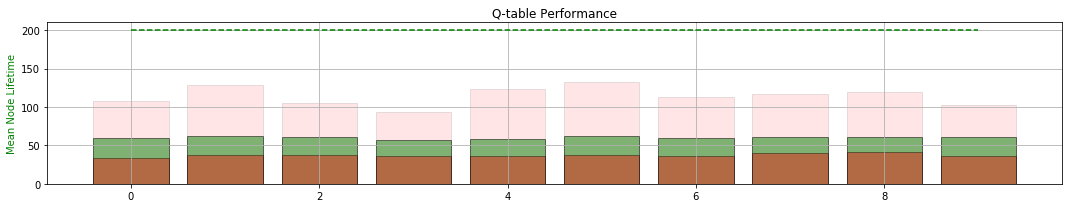

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 171.038	LOSS : 160.186	
Validating... MEAN TIME:  98.76
LOSS : 152.408	LOSS : 146.777	
Validating... MEAN TIME:  96.715
LOSS : 147.833	LOSS : 153.674	
Validating... MEAN TIME:  93.825
LOSS : 158.574	LOSS : 150.898	
Validating... MEAN TIME:  93.995
LOSS : 142.523	LOSS : 154.373	
Validating... MEAN TIME:  91.96
TRAINING TIME:0:00:23.598089


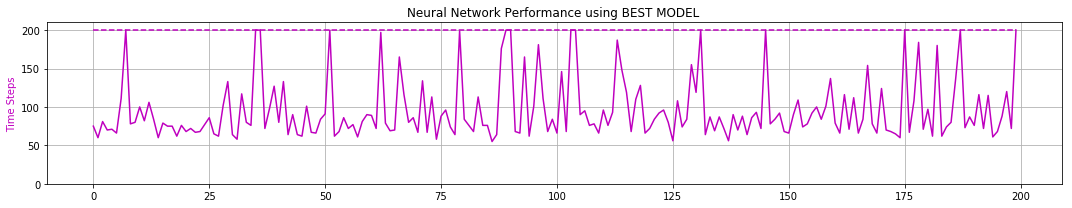

peak memory: 1478.86 MiB, increment: 1015.62 MiB
0 -max- [ 0.368  0.692  0.209  0.801]
0 -min- [-0.392 -1.249 -0.209 -0.822]

1 -max- [ 0.392  0.743  0.209  0.800]
1 -min- [-0.334 -1.076 -0.209 -0.787]

2 -max- [ 0.370  0.744  0.209  0.798]
2 -min- [-0.410 -1.125 -0.209 -0.817]

3 -max- [ 0.367  0.759  0.208  1.050]
3 -min- [-0.350 -1.143 -0.209 -0.817]

4 -max- [ 0.384  0.742  0.209  0.778]
4 -min- [-0.342 -1.115 -0.209 -0.775]

5 -max- [ 0.372  0.738  0.209  0.803]
5 -min- [-0.330 -1.108 -0.209 -0.755]

6 -max- [ 0.397  0.743  0.209  0.796]
6 -min- [-0.350 -1.088 -0.209 -0.779]

7 -max- [ 0.380  0.743  0.209  0.797]
7 -min- [-0.308 -1.127 -0.209 -0.775]

8 -max- [ 0.395  0.731  0.209  0.793]
8 -min- [-0.369 -1.133 -0.209 -0.999]

9 -max- [ 0.376  0.890  0.209  0.873]
9 -min- [-0.334 -1.154 -0.209 -0.820]

Quantization TIME:  0.02 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   61463
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 171
TOTAL SERIAL TIMESTEPS:   1185673
TOTAL PARALLEL T

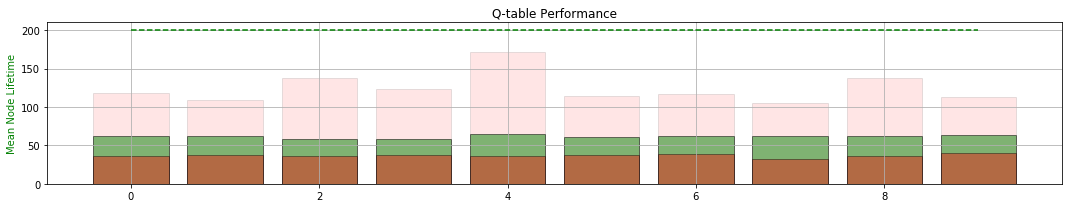

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 148.712	LOSS : 176.200	
Validating... MEAN TIME:  89.885
LOSS : 152.730	LOSS : 156.868	
Validating... MEAN TIME:  88.665
LOSS : 145.661	LOSS : 151.320	
Validating... MEAN TIME:  92.42
LOSS : 151.282	LOSS : 154.875	
Validating... MEAN TIME:  88.95
LOSS : 150.562	LOSS : 150.883	
Validating... MEAN TIME:  86.875
TRAINING TIME:0:00:23.087085


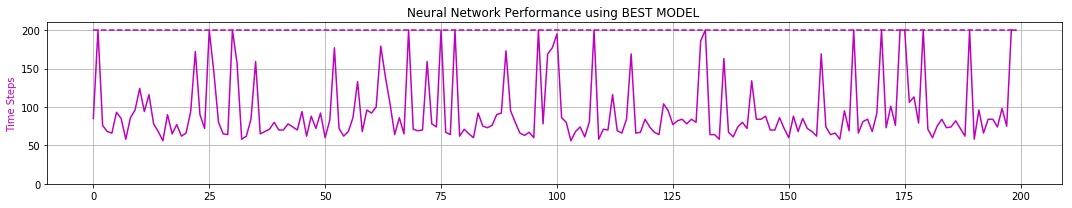

peak memory: 1463.96 MiB, increment: 1039.52 MiB
0 -max- [ 0.412  0.762  0.209  1.097]
0 -min- [-0.362 -1.126 -0.209 -0.804]

1 -max- [ 0.408  0.744  0.208  0.800]
1 -min- [-0.366 -1.114 -0.209 -0.790]

2 -max- [ 0.484  0.762  0.209  0.798]
2 -min- [-0.327 -1.085 -0.209 -0.818]

3 -max- [ 0.392  0.713  0.208  1.046]
3 -min- [-0.324 -1.150 -0.209 -0.838]

4 -max- [ 0.413  0.727  0.209  0.800]
4 -min- [-0.330 -1.122 -0.209 -0.756]

5 -max- [ 0.419  0.765  0.208  0.916]
5 -min- [-0.316 -1.088 -0.209 -0.760]

6 -max- [ 0.390  0.712  0.208  0.803]
6 -min- [-0.321 -1.129 -0.209 -0.826]

7 -max- [ 0.413  0.770  0.209  1.039]
7 -min- [-0.332 -1.108 -0.209 -0.859]

8 -max- [ 0.409  0.759  0.209  0.794]
8 -min- [-0.354 -1.131 -0.209 -0.834]

9 -max- [ 0.419  0.889  0.209  0.787]
9 -min- [-0.377 -1.113 -0.209 -0.802]

Quantization TIME:  0.02 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   62900
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 173
TOTAL SERIAL TIMESTEPS:   1248573
TOTAL PARALLEL T

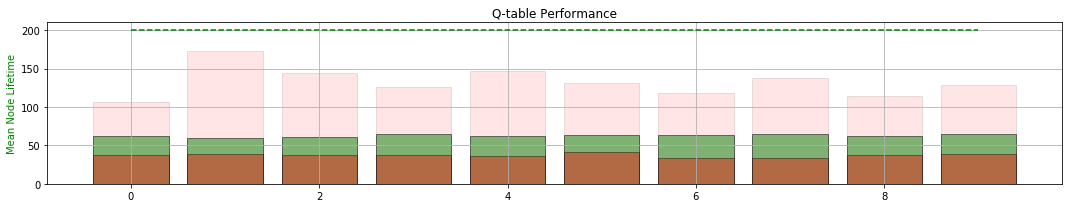

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 146.555	LOSS : 155.807	
Validating... MEAN TIME:  85.545
LOSS : 151.967	LOSS : 165.284	
Validating... MEAN TIME:  88.395
LOSS : 155.645	LOSS : 149.734	
Validating... MEAN TIME:  87.125
LOSS : 143.964	LOSS : 135.558	
Validating... MEAN TIME:  81.94
LOSS : 142.178	LOSS : 156.204	
Validating... MEAN TIME:  86.895
TRAINING TIME:0:00:23.032020


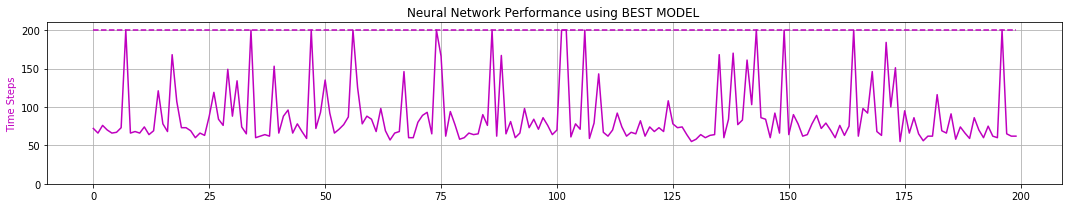

peak memory: 1464.80 MiB, increment: 1016.31 MiB
0 -max- [ 0.548  0.928  0.208  0.783]
0 -min- [-0.319 -1.112 -0.209 -0.825]

1 -max- [ 0.579  0.769  0.209  0.792]
1 -min- [-0.331 -1.257 -0.209 -0.832]

2 -max- [ 0.528  0.772  0.205  0.759]
2 -min- [-0.324 -1.100 -0.209 -0.795]

3 -max- [ 0.521  0.766  0.209  0.779]
3 -min- [-0.352 -1.140 -0.209 -0.819]

4 -max- [ 0.514  0.773  0.207  0.765]
4 -min- [-0.349 -1.078 -0.209 -0.833]

5 -max- [ 0.522  0.762  0.207  0.911]
5 -min- [-0.332 -1.146 -0.209 -0.850]

6 -max- [ 0.533  0.913  0.207  0.999]
6 -min- [-0.348 -1.072 -0.209 -0.829]

7 -max- [ 0.544  0.772  0.208  1.038]
7 -min- [-0.355 -1.148 -0.209 -0.784]

8 -max- [ 0.505  0.731  0.205  0.760]
8 -min- [-0.330 -1.114 -0.209 -0.830]

9 -max- [ 0.517  0.719  0.205  0.774]
9 -min- [-0.318 -1.137 -0.209 -0.808]

Quantization TIME:  0.02 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   62511
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 157
TOTAL SERIAL TIMESTEPS:   1311084
TOTAL PARALLEL T

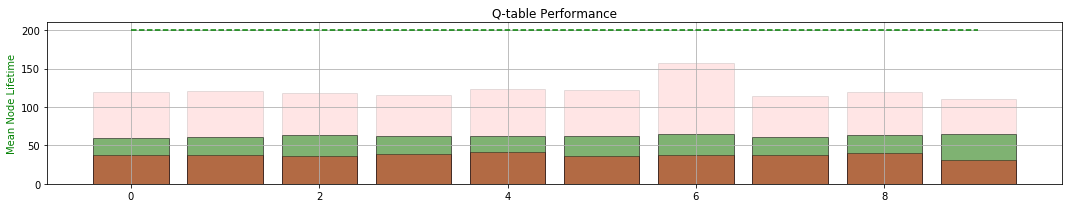

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 150.691	LOSS : 143.350	
Validating... MEAN TIME:  81.79
LOSS : 146.245	LOSS : 143.787	
Validating... MEAN TIME:  92.945
LOSS : 130.548	LOSS : 144.566	
Validating... MEAN TIME:  84.425
LOSS : 142.696	LOSS : 140.328	
Validating... MEAN TIME:  86.36
LOSS : 152.876	LOSS : 136.595	
Validating... MEAN TIME:  86.82
TRAINING TIME:0:00:23.008814


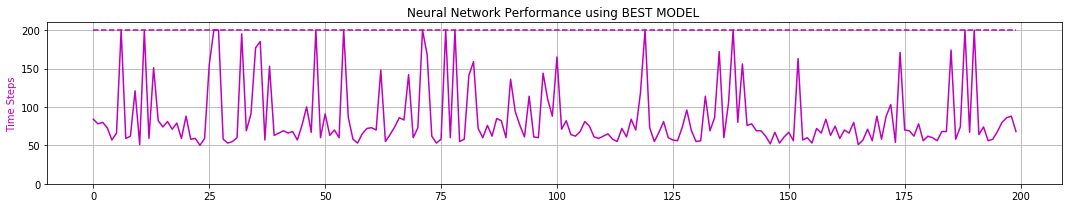

peak memory: 1425.62 MiB, increment: 1016.95 MiB
0 -max- [ 0.426  0.769  0.209  0.797]
0 -min- [-0.327 -1.265 -0.209 -0.831]

1 -max- [ 0.511  0.768  0.209  0.798]
1 -min- [-0.324 -1.087 -0.209 -0.795]

2 -max- [ 0.472  0.718  0.209  0.800]
2 -min- [-0.356 -1.111 -0.209 -0.831]

3 -max- [ 0.492  0.779  0.208  0.773]
3 -min- [-0.336 -1.088 -0.209 -0.764]

4 -max- [ 0.526  0.746  0.208  1.049]
4 -min- [-0.305 -1.086 -0.209 -0.800]

5 -max- [ 0.484  0.734  0.207  0.860]
5 -min- [-0.348 -1.081 -0.209 -0.791]

6 -max- [ 0.485  0.771  0.208  0.753]
6 -min- [-0.329 -1.121 -0.209 -0.814]

7 -max- [ 0.481  0.731  0.206  0.749]
7 -min- [-0.314 -1.101 -0.209 -0.998]

8 -max- [ 0.478  0.715  0.209  0.801]
8 -min- [-0.318 -1.087 -0.209 -0.827]

9 -max- [ 0.478  0.774  0.205  0.780]
9 -min- [-0.352 -1.085 -0.209 -0.832]

Quantization TIME:  0.01 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   63066
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 158
TOTAL SERIAL TIMESTEPS:   1374150
TOTAL PARALLEL T

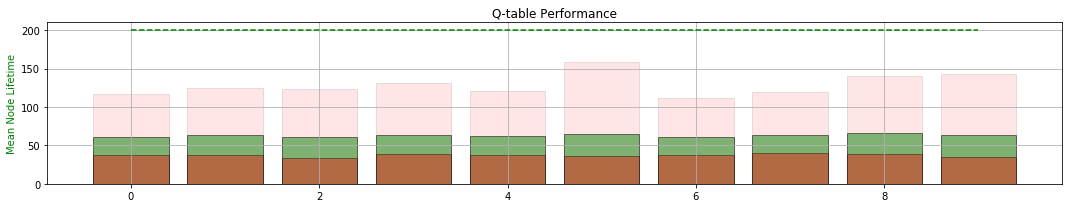

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 154.879	LOSS : 141.799	
Validating... MEAN TIME:  88.835
LOSS : 139.190	LOSS : 137.022	
Validating... MEAN TIME:  86.625
LOSS : 144.969	LOSS : 134.931	
Validating... MEAN TIME:  86.315
LOSS : 147.709	LOSS : 141.219	
Validating... MEAN TIME:  83.67
LOSS : 140.290	LOSS : 155.406	
Validating... MEAN TIME:  81.805
TRAINING TIME:0:00:22.636415


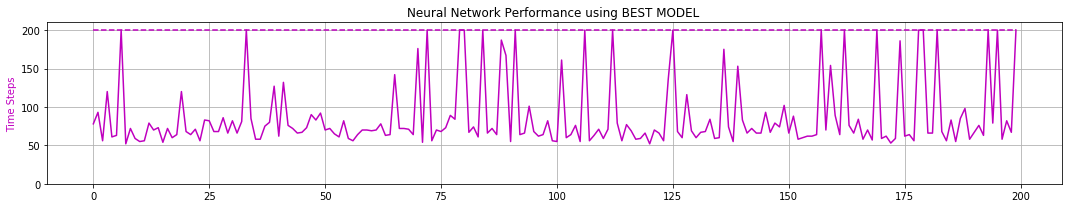

peak memory: 1435.12 MiB, increment: 1036.62 MiB
0 -max- [ 0.501  0.773  0.208  0.777]
0 -min- [-0.324 -1.150 -0.209 -0.833]

1 -max- [ 0.513  0.762  0.208  0.776]
1 -min- [-0.330 -1.080 -0.209 -0.798]

2 -max- [ 0.540  0.770  0.209  0.945]
2 -min- [-0.316 -1.088 -0.209 -0.831]

3 -max- [ 0.549  0.757  0.208  0.903]
3 -min- [-0.321 -1.145 -0.209 -0.898]

4 -max- [ 0.556  0.914  0.209  0.777]
4 -min- [-0.332 -1.129 -0.209 -0.800]

5 -max- [ 0.527  0.772  0.206  0.797]
5 -min- [-0.329 -1.087 -0.209 -0.780]

6 -max- [ 0.505  0.731  0.205  0.760]
6 -min- [-0.309 -1.101 -0.209 -0.970]

7 -max- [ 0.509  0.713  0.209  0.789]
7 -min- [-0.356 -1.087 -0.209 -0.846]

8 -max- [ 0.531  0.788  0.209  0.766]
8 -min- [-0.313 -1.109 -0.209 -0.832]

9 -max- [ 0.549  0.773  0.209  0.779]
9 -min- [-0.325 -1.149 -0.209 -1.024]

Quantization TIME:  0.01 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   64638
SMALLEST TIMESTEP: 33
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1438788
TOTAL PARALLEL T

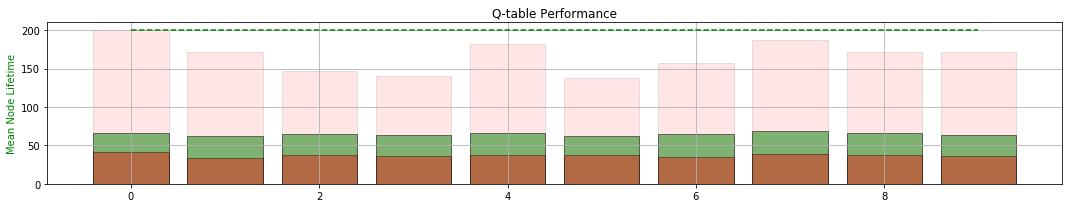

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 144.856	LOSS : 133.876	
Validating... MEAN TIME:  82.22
LOSS : 140.873	LOSS : 131.185	
Validating... MEAN TIME:  85.885
LOSS : 148.006	LOSS : 150.484	
Validating... MEAN TIME:  79.555
LOSS : 149.093	LOSS : 134.772	
Validating... MEAN TIME:  82.185
LOSS : 140.812	LOSS : 141.642	
Validating... MEAN TIME:  78.695
TRAINING TIME:0:00:21.964264


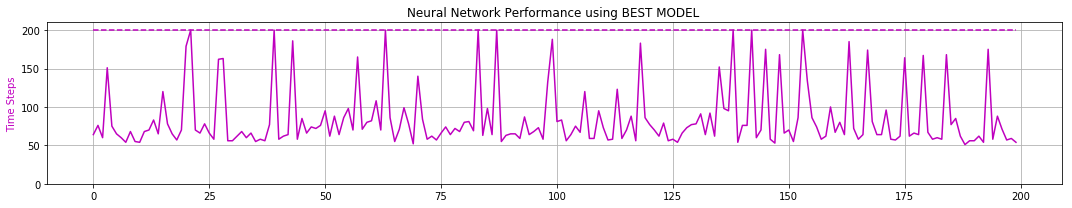

peak memory: 1454.65 MiB, increment: 997.44 MiB
0 -max- [ 0.556  0.769  0.208  0.768]
0 -min- [-0.330 -1.080 -0.209 -0.739]

1 -max- [ 0.524  0.776  0.209  1.060]
1 -min- [-0.346 -1.096 -0.209 -0.772]

2 -max- [ 0.540  0.762  0.209  0.901]
2 -min- [-0.332 -1.132 -0.209 -0.822]

3 -max- [ 0.550  0.780  0.209  0.799]
3 -min- [-0.310 -1.077 -0.209 -0.836]

4 -max- [ 0.561  0.709  0.204  0.804]
4 -min- [-0.329 -1.087 -0.209 -0.814]

5 -max- [ 0.542  0.577  0.202  0.797]
5 -min- [-0.333 -1.101 -0.209 -0.830]

6 -max- [ 0.544  0.716  0.204  0.801]
6 -min- [-0.315 -1.264 -0.209 -0.769]

7 -max- [ 0.537  0.758  0.209  0.803]
7 -min- [-0.361 -1.089 -0.209 -0.756]

8 -max- [ 0.568  0.779  0.209  0.780]
8 -min- [-0.315 -1.097 -0.209 -1.021]

9 -max- [ 0.563  0.865  0.205  0.788]
9 -min- [-0.329 -1.139 -0.209 -0.838]

Quantization TIME:  0.02 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   62193
SMALLEST TIMESTEP: 33
LARGEST  TIMESTEP: 139
TOTAL SERIAL TIMESTEPS:   1500981
TOTAL PARALLEL TI

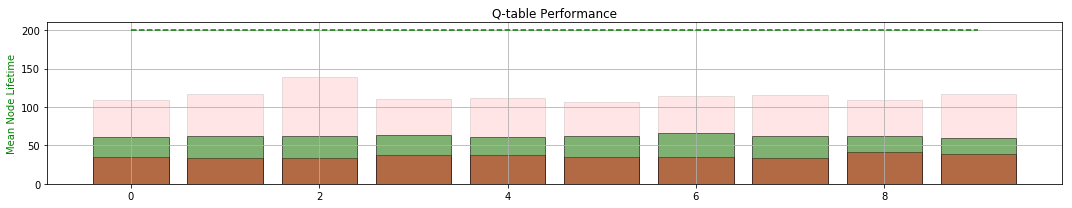

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 142.074	LOSS : 142.483	
Validating... MEAN TIME:  84.4
LOSS : 138.002	LOSS : 134.702	
Validating... MEAN TIME:  83.94
LOSS : 138.464	LOSS : 134.585	
Validating... MEAN TIME:  79.885
LOSS : 131.963	LOSS : 141.003	
Validating... MEAN TIME:  83.965
LOSS : 138.831	LOSS : 152.656	
Validating... MEAN TIME:  82.515
TRAINING TIME:0:00:21.994329


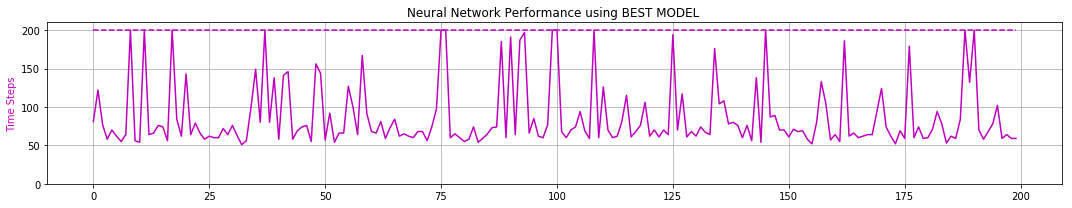

peak memory: 1454.79 MiB, increment: 1017.12 MiB
0 -max- [ 0.237  0.600  0.050  0.699]
0 -min- [-0.326 -1.079 -0.209 -0.833]

1 -max- [ 0.228  0.612  0.050  0.394]
1 -min- [-0.337 -1.089 -0.209 -0.935]

2 -max- [ 0.282  0.440  0.050  0.445]
2 -min- [-0.346 -1.129 -0.209 -1.045]

3 -max- [ 0.232  0.434  0.049  0.391]
3 -min- [-0.329 -1.089 -0.209 -0.821]

4 -max- [ 0.199  0.441  0.049  0.577]
4 -min- [-0.314 -1.101 -0.209 -0.830]

5 -max- [ 0.203  0.430  0.048  0.407]
5 -min- [-0.309 -1.088 -0.209 -0.829]

6 -max- [ 0.297  0.630  0.050  0.507]
6 -min- [-0.314 -1.438 -0.209 -0.837]

7 -max- [ 0.225  0.628  0.049  0.477]
7 -min- [-0.307 -1.089 -0.209 -1.063]

8 -max- [ 0.256  0.546  0.051  0.560]
8 -min- [-0.329 -1.139 -0.209 -0.920]

9 -max- [ 0.205  0.435  0.050  0.429]
9 -min- [-0.319 -1.085 -0.209 -0.817]

Quantization TIME:  0.01 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   60971
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 119
TOTAL SERIAL TIMESTEPS:   1561952
TOTAL PARALLEL T

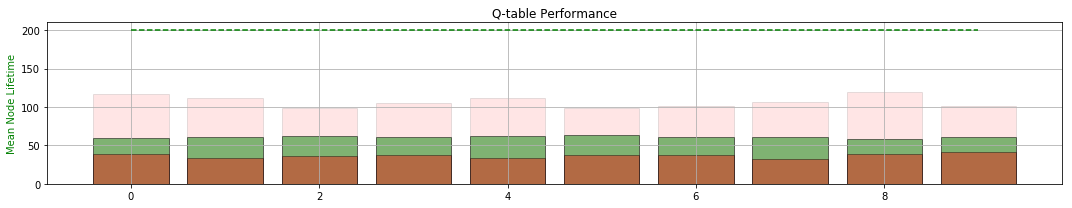

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 131.632	LOSS : 134.569	
Validating... MEAN TIME:  73.12
LOSS : 143.526	LOSS : 144.847	
Validating... MEAN TIME:  80.745
LOSS : 142.043	LOSS : 150.641	
Validating... MEAN TIME:  76.95
LOSS : 142.150	LOSS : 144.701	
Validating... MEAN TIME:  76.39
LOSS : 137.959	LOSS : 136.340	
Validating... MEAN TIME:  75.04
TRAINING TIME:0:00:20.783201


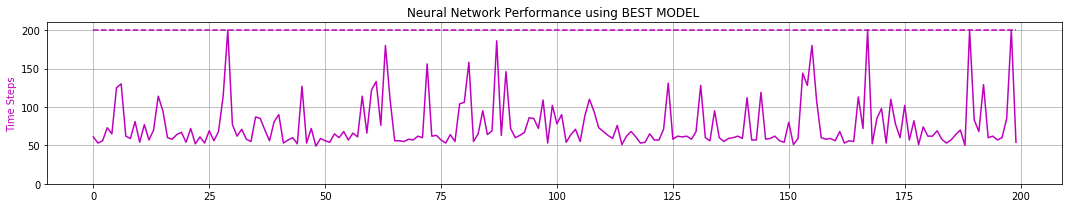

peak memory: 1441.78 MiB, increment: 1017.25 MiB
0 -max- [ 0.246  0.620  0.052  0.415]
0 -min- [-0.321 -1.111 -0.209 -0.903]

1 -max- [ 0.303  0.436  0.058  0.533]
1 -min- [-0.332 -1.102 -0.209 -0.836]

2 -max- [ 0.213  0.442  0.049  0.588]
2 -min- [-0.329 -1.141 -0.209 -0.833]

3 -max- [ 0.204  0.599  0.049  0.347]
3 -min- [-0.372 -1.115 -0.209 -0.896]

4 -max- [ 0.181  0.431  0.051  0.369]
4 -min- [-0.328 -1.142 -0.209 -0.773]

5 -max- [ 0.266  0.592  0.050  0.589]
5 -min- [-0.355 -1.085 -0.209 -0.833]

6 -max- [ 0.206  0.628  0.049  0.404]
6 -min- [-0.384 -1.100 -0.209 -1.112]

7 -max- [ 0.227  0.429  0.050  0.582]
7 -min- [-0.378 -1.139 -0.209 -0.957]

8 -max- [ 0.199  0.435  0.050  0.415]
8 -min- [-0.319 -1.088 -0.209 -0.789]

9 -max- [ 0.219  0.432  0.049  0.307]
9 -min- [-0.321 -1.145 -0.209 -0.791]

Quantization TIME:  0.02 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   60713
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 119
TOTAL SERIAL TIMESTEPS:   1622665
TOTAL PARALLEL T

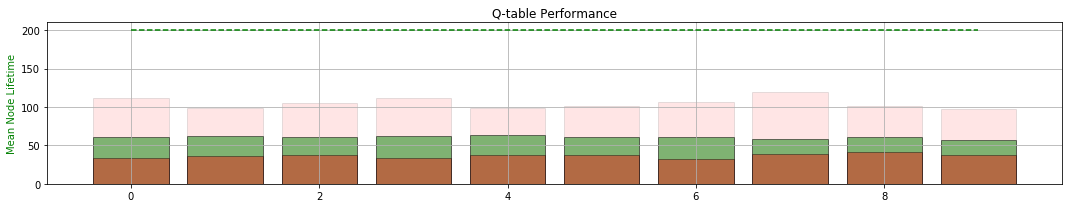

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 148.633	LOSS : 144.932	
Validating... MEAN TIME:  73.42
LOSS : 131.731	LOSS : 139.310	
Validating... MEAN TIME:  72.54
LOSS : 150.152	LOSS : 145.425	
Validating... MEAN TIME:  71.805
LOSS : 139.740	LOSS : 163.703	
Validating... MEAN TIME:  70.845
LOSS : 141.151	LOSS : 150.826	
Validating... MEAN TIME:  71.955
TRAINING TIME:0:00:19.493632


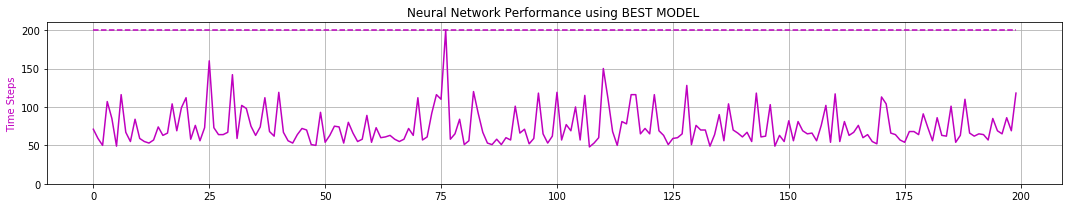

peak memory: 1420.87 MiB, increment: 1017.12 MiB
0 -max- [ 0.303  0.436  0.058  0.533]
0 -min- [-0.332 -1.102 -0.209 -0.836]

1 -max- [ 0.213  0.442  0.049  0.588]
1 -min- [-0.329 -1.141 -0.209 -0.833]

2 -max- [ 0.204  0.599  0.049  0.347]
2 -min- [-0.372 -1.115 -0.209 -0.896]

3 -max- [ 0.181  0.431  0.051  0.369]
3 -min- [-0.328 -1.142 -0.209 -0.773]

4 -max- [ 0.266  0.592  0.050  0.589]
4 -min- [-0.355 -1.085 -0.209 -0.833]

5 -max- [ 0.206  0.628  0.049  0.404]
5 -min- [-0.384 -1.100 -0.209 -1.112]

6 -max- [ 0.227  0.429  0.050  0.582]
6 -min- [-0.357 -1.139 -0.209 -0.957]

7 -max- [ 0.199  0.435  0.050  0.415]
7 -min- [-0.319 -1.088 -0.209 -0.789]

8 -max- [ 0.219  0.432  0.049  0.307]
8 -min- [-0.321 -1.145 -0.209 -0.791]

9 -max- [ 0.228  0.442  0.051  0.495]
9 -min- [-0.322 -1.084 -0.209 -0.786]

Quantization TIME:  0.02 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   59693
SMALLEST TIMESTEP: 33
LARGEST  TIMESTEP: 121
TOTAL SERIAL TIMESTEPS:   1682358
TOTAL PARALLEL T

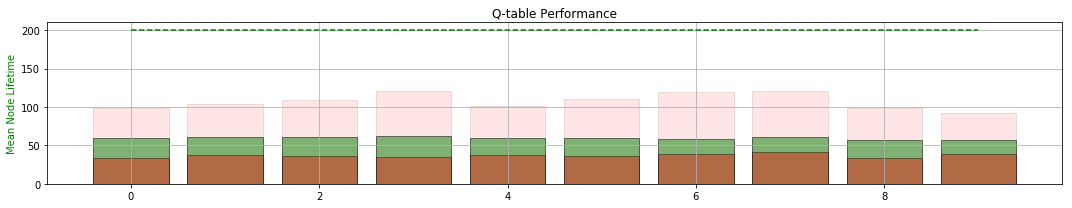

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 148.840	LOSS : 129.415	
Validating... MEAN TIME:  69.88
LOSS : 149.621	LOSS : 142.252	
Validating... MEAN TIME:  67.685
LOSS : 146.572	LOSS : 145.054	
Validating... MEAN TIME:  68.845
LOSS : 138.342	LOSS : 151.554	
Validating... MEAN TIME:  68.62
LOSS : 158.894	LOSS : 141.385	
Validating... MEAN TIME:  69.335
TRAINING TIME:0:00:20.129143


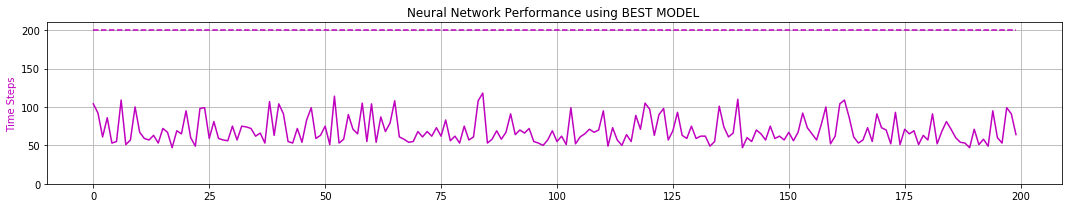

peak memory: 1451.72 MiB, increment: 1058.21 MiB
0 -max- [ 0.213  0.567  0.054  0.436]
0 -min- [-0.355 -1.094 -0.209 -0.838]

1 -max- [ 0.182  0.605  0.049  0.419]
1 -min- [-0.350 -1.256 -0.209 -1.041]

2 -max- [ 0.174  0.577  0.048  0.375]
2 -min- [-0.338 -1.087 -0.209 -0.812]

3 -max- [ 0.247  0.593  0.052  0.609]
3 -min- [-0.317 -1.123 -0.209 -0.942]

4 -max- [ 0.201  0.612  0.049  0.437]
4 -min- [-0.356 -1.144 -0.209 -0.935]

5 -max- [ 0.165  0.563  0.050  0.403]
5 -min- [-0.329 -1.280 -0.209 -0.831]

6 -max- [ 0.186  0.438  0.050  0.349]
6 -min- [-0.319 -1.099 -0.209 -0.784]

7 -max- [ 0.219  0.440  0.049  0.373]
7 -min- [-0.321 -1.089 -0.209 -0.792]

8 -max- [ 0.196  0.625  0.048  0.437]
8 -min- [-0.314 -1.133 -0.209 -0.977]

9 -max- [ 0.176  0.575  0.049  0.360]
9 -min- [-0.323 -1.087 -0.209 -0.776]

Quantization TIME:  0.02 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   57056
SMALLEST TIMESTEP: 29
LARGEST  TIMESTEP: 120
TOTAL SERIAL TIMESTEPS:   1739414
TOTAL PARALLEL T

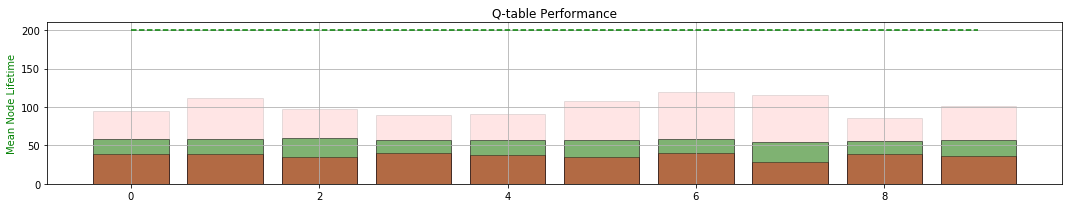

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 148.801	LOSS : 141.419	
Validating... MEAN TIME:  68.85
LOSS : 146.068	LOSS : 155.411	
Validating... MEAN TIME:  70.13
LOSS : 145.716	LOSS : 140.879	
Validating... MEAN TIME:  68.355
LOSS : 138.080	LOSS : 152.134	
Validating... MEAN TIME:  68.88
LOSS : 141.626	LOSS : 158.366	
Validating... MEAN TIME:  67.915
TRAINING TIME:0:00:19.576138


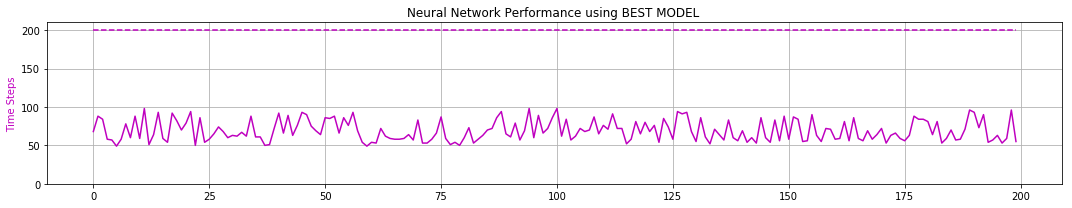

peak memory: 1449.45 MiB, increment: 1036.92 MiB
0 -max- [ 0.166  0.439  0.049  0.372]
0 -min- [-0.338 -1.088 -0.209 -0.815]

1 -max- [ 0.174  0.438  0.048  0.358]
1 -min- [-0.360 -1.120 -0.209 -0.835]

2 -max- [ 0.177  0.457  0.050  0.360]
2 -min- [-0.363 -1.087 -0.209 -1.042]

3 -max- [ 0.178  0.610  0.049  0.376]
3 -min- [-0.339 -1.089 -0.209 -0.962]

4 -max- [ 0.156  0.740  0.050  0.382]
4 -min- [-0.350 -1.146 -0.209 -1.157]

5 -max- [ 0.236  0.558  0.050  0.372]
5 -min- [-0.319 -1.111 -0.209 -0.902]

6 -max- [ 0.186  0.436  0.049  0.379]
6 -min- [-0.348 -1.127 -0.209 -0.800]

7 -max- [ 0.151  0.563  0.048  0.338]
7 -min- [-0.354 -1.269 -0.209 -1.069]

8 -max- [ 0.160  0.438  0.049  0.536]
8 -min- [-0.320 -1.113 -0.209 -0.749]

9 -max- [ 0.181  0.423  0.050  0.347]
9 -min- [-0.335 -1.085 -0.209 -0.831]

Quantization TIME:  0.02 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   50852
SMALLEST TIMESTEP: 35
LARGEST  TIMESTEP: 73
TOTAL SERIAL TIMESTEPS:   1790266
TOTAL PARALLEL TI

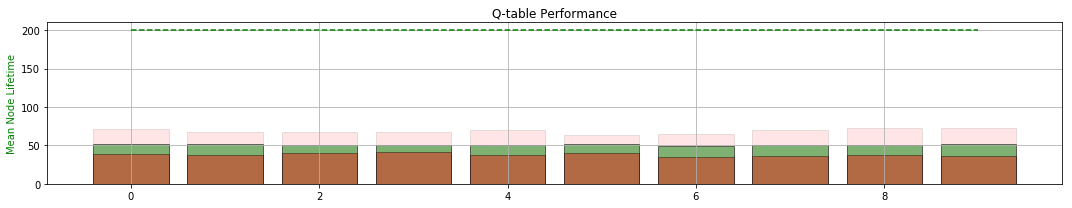

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 150.975	LOSS : 144.689	
Validating... MEAN TIME:  67.365
LOSS : 151.893	LOSS : 154.003	
Validating... MEAN TIME:  66.895
LOSS : 149.123	LOSS : 154.342	
Validating... MEAN TIME:  65.83
LOSS : 144.792	LOSS : 161.187	
Validating... MEAN TIME:  65.525
LOSS : 147.945	LOSS : 156.885	
Validating... MEAN TIME:  65.085
TRAINING TIME:0:00:18.680134


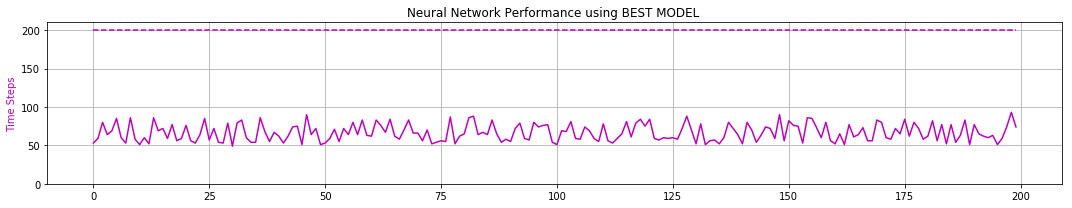

peak memory: 1449.45 MiB, increment: 978.19 MiB
0 -max- [ 0.137  0.622  0.048  0.300]
0 -min- [-0.318 -1.124 -0.209 -0.879]

1 -max- [ 0.158  0.593  0.050  0.475]
1 -min- [-0.368 -1.249 -0.209 -0.924]

2 -max- [ 0.150  0.589  0.049  0.369]
2 -min- [-0.356 -1.139 -0.209 -0.834]

3 -max- [ 0.145  0.624  0.050  0.373]
3 -min- [-0.311 -1.134 -0.209 -1.327]

4 -max- [ 0.133  0.633  0.050  0.351]
4 -min- [-0.356 -1.087 -0.209 -0.793]

5 -max- [ 0.156  0.588  0.049  0.334]
5 -min- [-0.335 -1.138 -0.209 -0.842]

6 -max- [ 0.136  0.629  0.048  0.346]
6 -min- [-0.305 -1.235 -0.209 -1.016]

7 -max- [ 0.128  0.556  0.049  0.344]
7 -min- [-0.320 -1.112 -0.209 -0.819]

8 -max- [ 0.154  0.438  0.050  0.344]
8 -min- [-0.312 -1.127 -0.209 -0.814]

9 -max- [ 0.162  0.623  0.050  0.379]
9 -min- [-0.314 -1.127 -0.209 -0.895]

Quantization TIME:  0.02 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   46452
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 64
TOTAL SERIAL TIMESTEPS:   1836718
TOTAL PARALLEL TIM

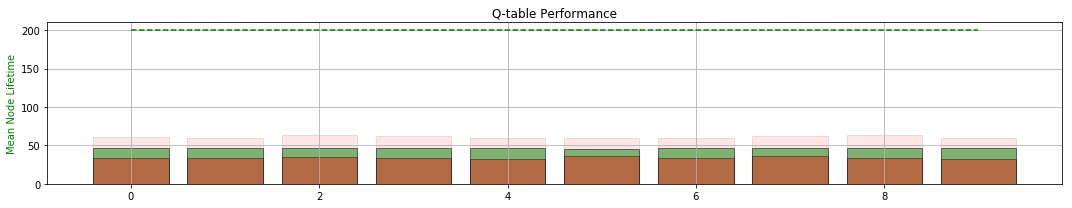

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 151.382	LOSS : 171.047	
Validating... MEAN TIME:  62.42
LOSS : 163.607	LOSS : 161.937	
Validating... MEAN TIME:  62.305
LOSS : 158.826	LOSS : 147.662	
Validating... MEAN TIME:  58.43
LOSS : 152.516	LOSS : 162.612	
Validating... MEAN TIME:  59.475
LOSS : 144.624	LOSS : 153.443	
Validating... MEAN TIME:  59.53
TRAINING TIME:0:00:18.077312


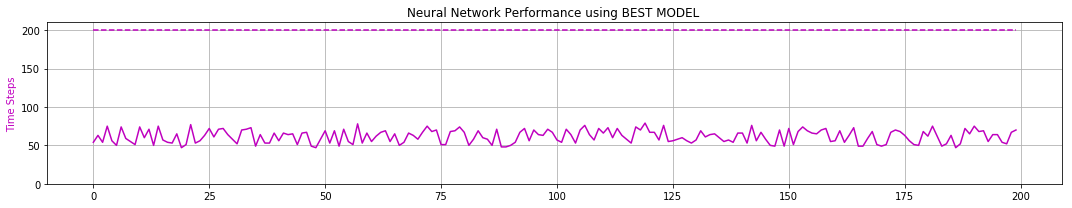

peak memory: 1468.98 MiB, increment: 978.05 MiB
0 -max- [ 0.155  0.616  0.050  0.330]
0 -min- [-0.315 -0.961 -0.209 -0.837]

1 -max- [ 0.147  0.767  0.049  0.357]
1 -min- [-0.302 -1.088 -0.209 -1.164]

2 -max- [ 0.147  0.595  0.050  0.256]
2 -min- [-0.301 -1.088 -0.209 -1.128]

3 -max- [ 0.140  0.608  0.050  0.328]
3 -min- [-0.318 -1.087 -0.209 -0.911]

4 -max- [ 0.149  0.634  0.049  0.279]
4 -min- [-0.309 -1.073 -0.209 -0.882]

5 -max- [ 0.140  0.624  0.048  0.364]
5 -min- [-0.338 -1.056 -0.209 -0.910]

6 -max- [ 0.133  0.440  0.049  0.330]
6 -min- [-0.305 -1.119 -0.209 -0.835]

7 -max- [ 0.147  0.568  0.050  0.526]
7 -min- [-0.311 -1.067 -0.209 -0.936]

8 -max- [ 0.156  0.623  0.050  0.326]
8 -min- [-0.281 -1.075 -0.209 -0.994]

9 -max- [ 0.173  0.800  0.050  0.357]
9 -min- [-0.296 -1.090 -0.209 -1.171]

Quantization TIME:  0.02 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   36315
SMALLEST TIMESTEP: 23
LARGEST  TIMESTEP: 51
TOTAL SERIAL TIMESTEPS:   1873033
TOTAL PARALLEL TIM

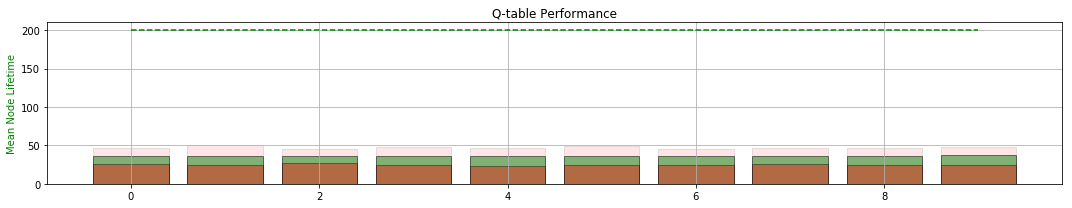

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 174.024	LOSS : 178.690	
Validating... MEAN TIME:  55.755
LOSS : 173.419	LOSS : 169.446	
Validating... MEAN TIME:  52.095
LOSS : 162.769	LOSS : 178.842	
Validating... MEAN TIME:  51.175
LOSS : 185.311	LOSS : 167.877	
Validating... MEAN TIME:  50.61
LOSS : 180.675	LOSS : 173.980	
Validating... MEAN TIME:  51.225
TRAINING TIME:0:00:16.722519


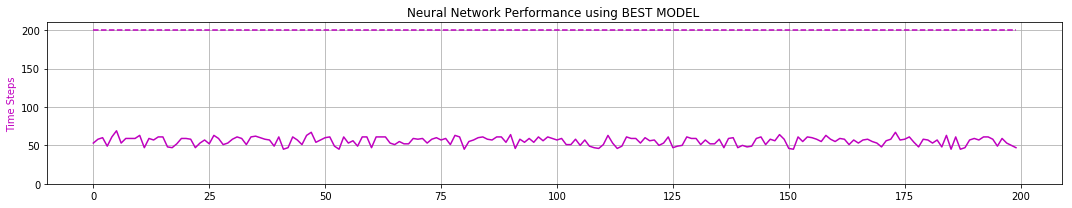

peak memory: 1423.50 MiB, increment: 1034.99 MiB
0 -max- [ 0.173  0.735  0.049  0.332]
0 -min- [-0.221 -0.943 -0.209 -1.218]

1 -max- [ 0.172  0.631  0.050  0.349]
1 -min- [-0.192 -0.948 -0.209 -1.067]

2 -max- [ 0.160  0.631  0.050  0.300]
2 -min- [-0.209 -0.959 -0.209 -0.885]

3 -max- [ 0.175  0.584  0.049  0.272]
3 -min- [-0.205 -0.959 -0.209 -1.098]

4 -max- [ 0.171  0.592  0.048  0.542]
4 -min- [-0.269 -0.954 -0.209 -1.045]

5 -max- [ 0.165  0.623  0.049  0.340]
5 -min- [-0.228 -0.962 -0.209 -1.074]

6 -max- [ 0.177  0.608  0.050  0.258]
6 -min- [-0.197 -0.965 -0.209 -1.016]

7 -max- [ 0.184  0.625  0.053  0.347]
7 -min- [-0.186 -0.957 -0.209 -1.023]

8 -max- [ 0.184  0.627  0.050  0.336]
8 -min- [-0.251 -1.128 -0.209 -1.074]

9 -max- [ 0.183  0.628  0.050  0.322]
9 -min- [-0.185 -0.942 -0.209 -1.027]

Quantization TIME:  0.02 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   32407
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   1905440
TOTAL PARALLEL TI

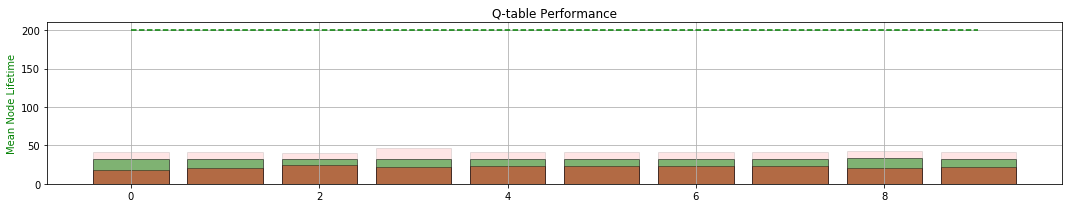

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 204.707	LOSS : 211.880	
Validating... MEAN TIME:  47.485
LOSS : 204.174	LOSS : 190.860	
Validating... MEAN TIME:  46.435
LOSS : 195.785	LOSS : 197.859	
Validating... MEAN TIME:  45.85
LOSS : 190.666	LOSS : 194.662	
Validating... MEAN TIME:  46.37
LOSS : 202.513	LOSS : 184.659	
Validating... MEAN TIME:  47.66
TRAINING TIME:0:00:15.550626


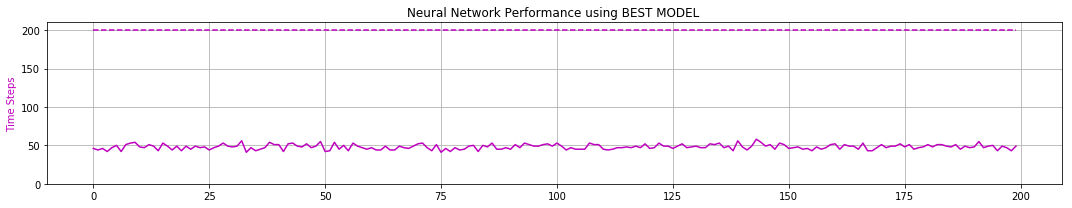

peak memory: 1423.50 MiB, increment: 977.79 MiB
0 -max- [ 0.193  0.834  0.050  0.310]
0 -min- [-0.154 -0.932 -0.209 -1.473]

1 -max- [ 0.168  0.607  0.050  0.169]
1 -min- [-0.165 -0.959 -0.209 -1.094]

2 -max- [ 0.188  0.625  0.049  0.319]
2 -min- [-0.211 -0.960 -0.209 -1.002]

3 -max- [ 0.177  0.639  0.048  0.327]
3 -min- [-0.188 -0.957 -0.209 -1.117]

4 -max- [ 0.177  0.637  0.049  0.258]
4 -min- [-0.181 -0.940 -0.209 -1.049]

5 -max- [ 0.185  0.587  0.050  0.239]
5 -min- [-0.197 -0.963 -0.209 -0.881]

6 -max- [ 0.197  0.643  0.050  0.280]
6 -min- [-0.181 -0.961 -0.209 -1.056]

7 -max- [ 0.212  0.624  0.054  0.303]
7 -min- [-0.154 -0.930 -0.209 -1.085]

8 -max- [ 0.197  0.445  0.050  0.278]
8 -min- [-0.250 -0.956 -0.209 -0.791]

9 -max- [ 0.187  0.639  0.048  0.277]
9 -min- [-0.168 -0.918 -0.209 -1.109]

Quantization TIME:  0.02 minutes


ITERATION # 32
TOTAL EXPERIENCE GENERATED:   21244
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 34
TOTAL SERIAL TIMESTEPS:   1926684
TOTAL PARALLEL TIM

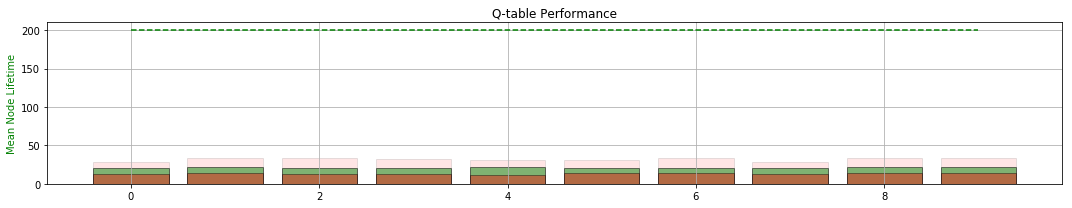

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 250.873	LOSS : 223.371	
Validating... MEAN TIME:  45.235
LOSS : 265.174	LOSS : 234.039	
Validating... MEAN TIME:  44.0
LOSS : 237.829	LOSS : 236.994	
Validating... MEAN TIME:  46.61
LOSS : 227.974	LOSS : 232.055	
Validating... MEAN TIME:  47.46
LOSS : 252.575	LOSS : 223.261	
Validating... MEAN TIME:  49.065
TRAINING TIME:0:00:15.864959


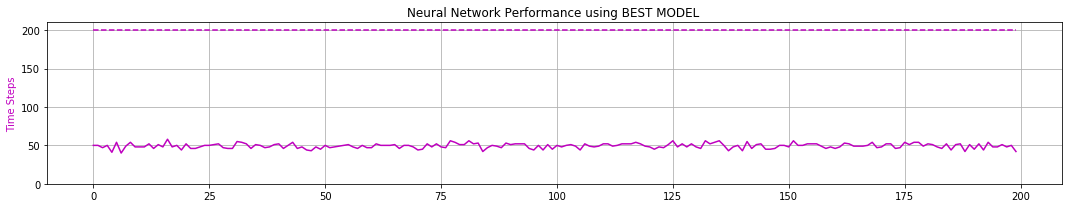

peak memory: 1423.63 MiB, increment: 1017.24 MiB
0 -max- [ 0.194  0.828  0.050  0.067]
0 -min- [-0.048 -0.592 -0.209 -1.247]

1 -max- [ 0.209  0.642  0.049  0.281]
1 -min- [-0.089 -0.754 -0.209 -1.092]

2 -max- [ 0.211  0.817  0.054  0.348]
2 -min- [-0.059 -0.597 -0.209 -1.315]

3 -max- [ 0.197  0.797  0.049  0.079]
3 -min- [-0.074 -0.767 -0.209 -1.418]

4 -max- [ 0.210  0.639  0.051  0.293]
4 -min- [-0.059 -0.746 -0.209 -1.098]

5 -max- [ 0.207  0.817  0.050  0.302]
5 -min- [-0.049 -0.593 -0.209 -1.391]

6 -max- [ 0.219  0.811  0.050  0.226]
6 -min- [-0.050 -0.591 -0.209 -1.508]

7 -max- [ 0.217  0.816  0.050  0.253]
7 -min- [-0.070 -0.760 -0.209 -1.236]

8 -max- [ 0.192  0.798  0.048  0.277]
8 -min- [-0.083 -0.744 -0.209 -1.350]

9 -max- [ 0.196  0.832  0.050  0.299]
9 -min- [-0.050 -0.594 -0.209 -1.234]

Quantization TIME:  0.02 minutes


ITERATION # 33
TOTAL EXPERIENCE GENERATED:   19102
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 36
TOTAL SERIAL TIMESTEPS:   1945786
TOTAL PARALLEL TI

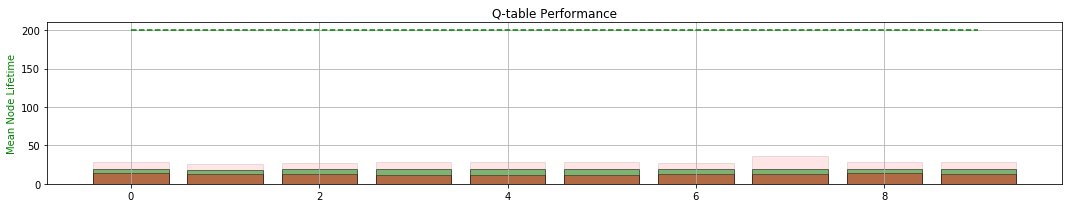

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 272.676	LOSS : 261.604	
Validating... MEAN TIME:  46.705
LOSS : 261.279	LOSS : 269.580	
Validating... MEAN TIME:  50.02
LOSS : 258.527	LOSS : 268.738	
Validating... MEAN TIME:  51.125
LOSS : 252.764	LOSS : 271.722	
Validating... MEAN TIME:  52.405
LOSS : 252.422	LOSS : 247.502	
Validating... MEAN TIME:  58.8
TRAINING TIME:0:00:16.261243


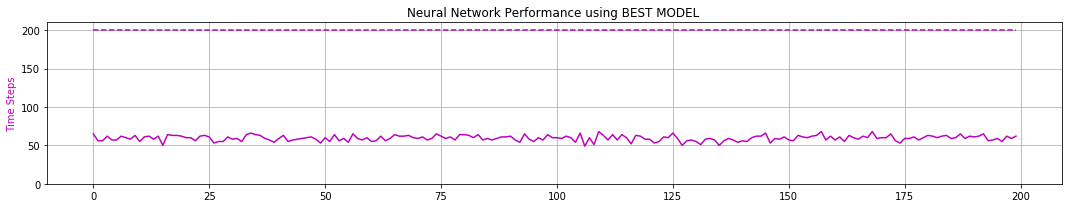

peak memory: 1406.84 MiB, increment: 1036.42 MiB
0 -max- [ 0.212  0.788  0.049  0.049]
0 -min- [-0.049 -0.593 -0.209 -1.246]

1 -max- [ 0.211  0.834  0.048  0.050]
1 -min- [-0.049 -0.582 -0.209 -1.380]

2 -max- [ 0.201  0.803  0.049  0.063]
2 -min- [-0.050 -0.573 -0.209 -1.235]

3 -max- [ 0.210  0.754  0.050  0.062]
3 -min- [-0.050 -0.585 -0.209 -1.174]

4 -max- [ 0.215  0.830  0.050  0.305]
4 -min- [-0.049 -0.412 -0.209 -1.392]

5 -max- [ 0.219  0.814  0.050  0.049]
5 -min- [-0.050 -0.572 -0.209 -1.339]

6 -max- [ 0.218  0.796  0.050  0.050]
6 -min- [-0.050 -0.574 -0.209 -1.148]

7 -max- [ 0.194  0.823  0.048  0.296]
7 -min- [-0.109 -0.780 -0.209 -1.441]

8 -max- [ 0.205  0.822  0.050  0.059]
8 -min- [-0.050 -0.595 -0.209 -1.358]

9 -max- [ 0.194  0.827  0.049  0.319]
9 -min- [-0.052 -0.559 -0.209 -1.310]

Quantization TIME:  0.02 minutes


ITERATION # 34
TOTAL EXPERIENCE GENERATED:   18585
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 27
TOTAL SERIAL TIMESTEPS:   1964371
TOTAL PARALLEL TI

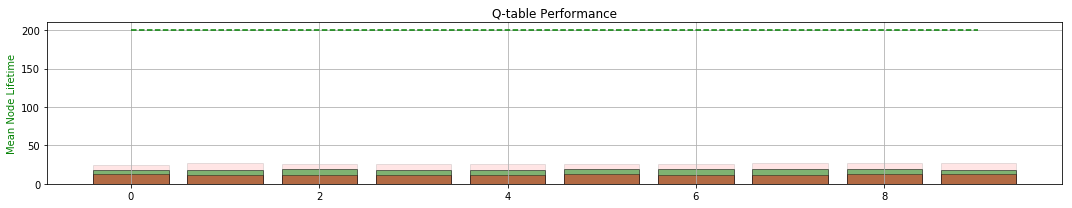

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 277.254	LOSS : 284.456	
Validating... MEAN TIME:  57.845
LOSS : 301.433	LOSS : 272.039	
Validating... MEAN TIME:  70.635
LOSS : 311.035	LOSS : 300.073	
Validating... MEAN TIME:  67.98
LOSS : 293.228	LOSS : 298.618	
Validating... MEAN TIME:  77.51
LOSS : 297.747	LOSS : 281.874	
Validating... MEAN TIME:  119.555
TRAINING TIME:0:00:21.492167


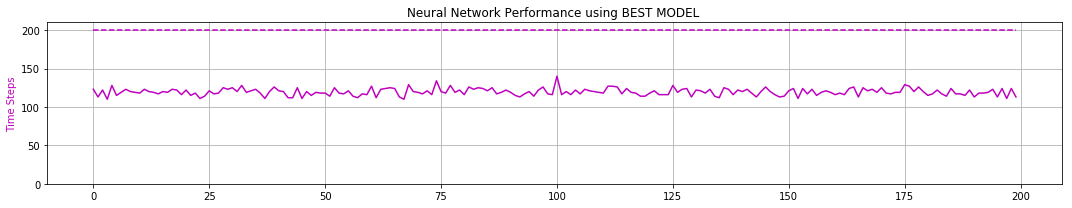

peak memory: 1452.92 MiB, increment: 1023.78 MiB
0 -max- [ 0.211  0.833  0.048  0.259]
0 -min- [-0.049 -0.582 -0.209 -1.376]

1 -max- [ 0.201  0.818  0.049  0.069]
1 -min- [-0.050 -0.573 -0.209 -1.322]

2 -max- [ 0.210  0.816  0.050  0.049]
2 -min- [-0.050 -0.585 -0.209 -1.245]

3 -max- [ 0.215  0.831  0.050  0.290]
3 -min- [-0.049 -0.409 -0.209 -1.172]

4 -max- [ 0.219  0.819  0.050  0.289]
4 -min- [-0.050 -0.572 -0.209 -1.376]

5 -max- [ 0.218  0.826  0.050  0.327]
5 -min- [-0.050 -0.574 -0.209 -1.274]

6 -max- [ 0.194  0.832  0.048  0.343]
6 -min- [-0.047 -0.600 -0.209 -1.305]

7 -max- [ 0.205  0.838  0.050  0.059]
7 -min- [-0.050 -0.595 -0.209 -1.417]

8 -max- [ 0.194  0.818  0.049  0.061]
8 -min- [-0.050 -0.583 -0.209 -1.361]

9 -max- [ 0.214  0.833  0.050  0.054]
9 -min- [-0.049 -0.412 -0.209 -1.434]

Quantization TIME:  0.02 minutes


ITERATION # 35
TOTAL EXPERIENCE GENERATED:   19926
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 33
TOTAL SERIAL TIMESTEPS:   1984297
TOTAL PARALLEL TI

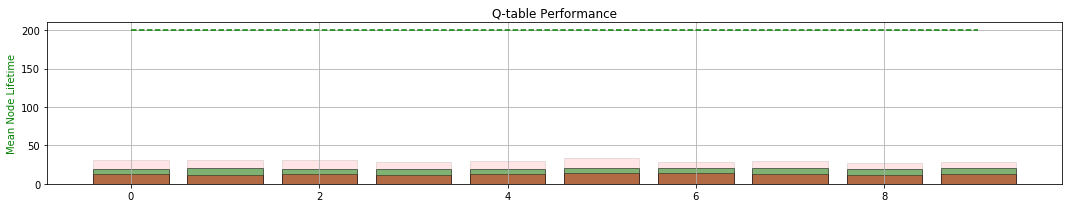

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 330.826	LOSS : 349.255	
Validating... MEAN TIME:  105.58
LOSS : 323.682	LOSS : 326.403	
Validating... MEAN TIME:  120.195
LOSS : 349.994	LOSS : 319.170	
Validating... MEAN TIME:  130.225
LOSS : 316.367	LOSS : 318.540	
Validating... MEAN TIME:  146.165
LOSS : 328.353	LOSS : 346.998	
Validating... MEAN TIME:  148.72
TRAINING TIME:0:00:31.255254


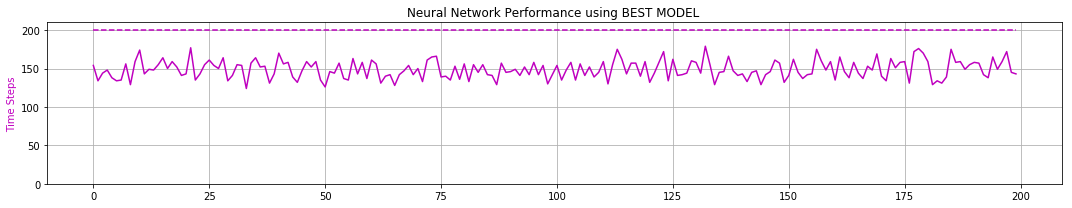

peak memory: 1441.72 MiB, increment: 1023.80 MiB
0 -max- [ 0.201  0.778  0.049  0.063]
0 -min- [-0.050 -0.596 -0.209 -1.364]

1 -max- [ 0.210  0.822  0.050  0.072]
1 -min- [-0.050 -0.599 -0.209 -1.399]

2 -max- [ 0.215  0.809  0.050  0.322]
2 -min- [-0.053 -0.590 -0.209 -1.392]

3 -max- [ 0.225  0.800  0.050  0.279]
3 -min- [-0.050 -0.588 -0.209 -1.218]

4 -max- [ 0.218  0.796  0.050  0.320]
4 -min- [-0.050 -0.591 -0.209 -1.209]

5 -max- [ 0.193  0.795  0.048  0.225]
5 -min- [-0.055 -0.600 -0.209 -1.211]

6 -max- [ 0.205  0.835  0.050  0.340]
6 -min- [-0.050 -0.596 -0.209 -1.312]

7 -max- [ 0.194  0.836  0.049  0.075]
7 -min- [-0.050 -0.583 -0.209 -1.439]

8 -max- [ 0.214  0.813  0.050  0.253]
8 -min- [-0.049 -0.582 -0.209 -1.196]

9 -max- [ 0.185  0.832  0.049  0.269]
9 -min- [-0.050 -0.751 -0.209 -1.442]

Quantization TIME:  0.02 minutes


ITERATION # 36
TOTAL EXPERIENCE GENERATED:   20057
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 31
TOTAL SERIAL TIMESTEPS:   2004354
TOTAL PARALLEL TI

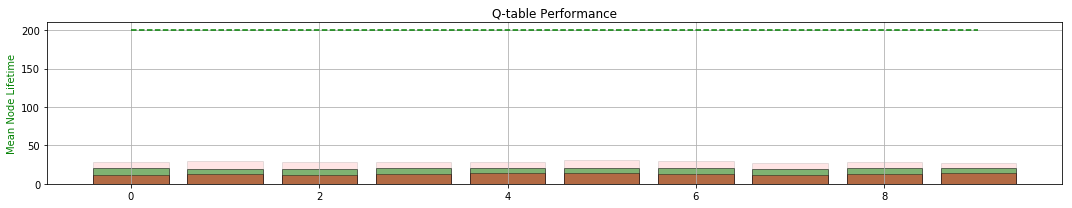

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 358.352	LOSS : 356.648	
Validating... MEAN TIME:  186.065
LOSS : 346.540	LOSS : 358.263	
Validating... MEAN TIME:  182.07
LOSS : 352.504	LOSS : 352.679	
Validating... MEAN TIME:  182.235
LOSS : 372.163	LOSS : 341.368	
Validating... MEAN TIME:  156.96
LOSS : 343.821	LOSS : 366.870	
Validating... MEAN TIME:  165.74
TRAINING TIME:0:00:38.995732


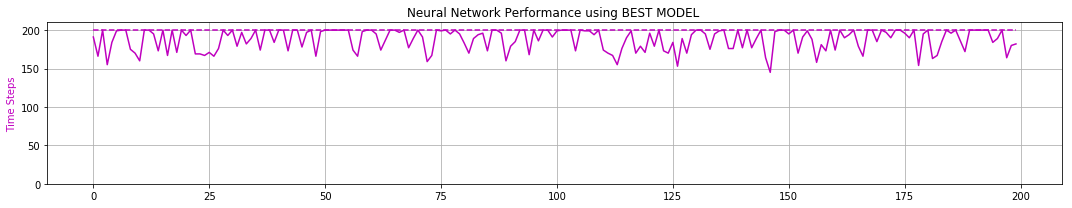

peak memory: 1439.04 MiB, increment: 1036.26 MiB
0 -max- [ 0.210  0.790  0.051  0.284]
0 -min- [-0.050 -0.599 -0.209 -1.179]

1 -max- [ 0.215  0.799  0.050  0.063]
1 -min- [-0.049 -0.581 -0.209 -1.342]

2 -max- [ 0.219  0.800  0.050  0.264]
2 -min- [-0.050 -0.588 -0.209 -1.204]

3 -max- [ 0.218  0.798  0.050  0.214]
3 -min- [-0.050 -0.591 -0.209 -1.197]

4 -max- [ 0.193  0.784  0.048  0.260]
4 -min- [-0.055 -0.593 -0.209 -1.350]

5 -max- [ 0.205  0.835  0.054  0.340]
5 -min- [-0.050 -0.592 -0.209 -1.262]

6 -max- [ 0.194  0.835  0.053  0.289]
6 -min- [-0.050 -0.583 -0.209 -1.393]

7 -max- [ 0.214  0.813  0.050  0.253]
7 -min- [-0.049 -0.582 -0.209 -1.196]

8 -max- [ 0.182  0.822  0.049  0.269]
8 -min- [-0.050 -0.751 -0.209 -1.442]

9 -max- [ 0.217  0.644  0.049  0.070]
9 -min- [-0.050 -0.557 -0.209 -1.106]

Quantization TIME:  0.02 minutes


ITERATION # 37
TOTAL EXPERIENCE GENERATED:   21083
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 102
TOTAL SERIAL TIMESTEPS:   2025437
TOTAL PARALLEL T

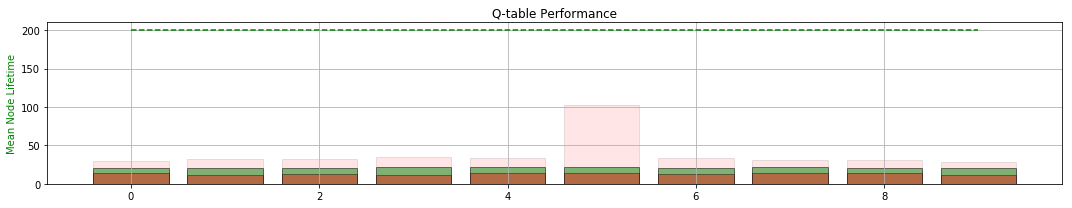

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 369.967	LOSS : 389.038	
Validating... MEAN TIME:  167.075
LOSS : 378.592	LOSS : 367.856	
Validating... MEAN TIME:  149.285
LOSS : 383.969	LOSS : 381.572	
Validating... MEAN TIME:  119.47
LOSS : 386.022	LOSS : 391.251	
Validating... MEAN TIME:  124.9
LOSS : 377.836	LOSS : 387.365	
Validating... MEAN TIME:  147.58
TRAINING TIME:0:00:32.527992


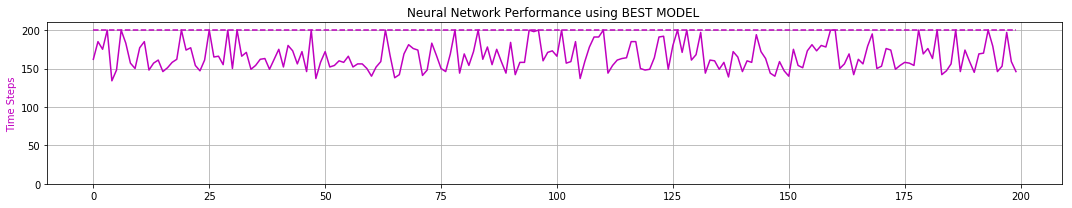

peak memory: 1439.04 MiB, increment: 977.79 MiB
0 -max- [ 0.215  0.793  0.050  0.242]
0 -min- [-0.057 -0.592 -0.209 -1.300]

1 -max- [ 0.219  0.806  0.050  0.303]
1 -min- [-0.068 -0.750 -0.209 -1.210]

2 -max- [ 0.218  0.822  0.050  0.253]
2 -min- [-0.070 -0.760 -0.209 -1.377]

3 -max- [ 0.194  0.832  0.048  0.272]
3 -min- [-0.079 -0.781 -0.209 -1.321]

4 -max- [ 0.205  0.824  0.050  0.299]
4 -min- [-0.061 -0.594 -0.209 -1.396]

5 -max- [ 0.194  0.836  0.049  0.625]
5 -min- [-2.387 -2.239 -0.209 -1.439]

6 -max- [ 0.214  0.827  0.055  0.282]
6 -min- [-0.049 -0.596 -0.209 -1.116]

7 -max- [ 0.176  0.826  0.049  0.282]
7 -min- [-0.050 -0.749 -0.209 -1.385]

8 -max- [ 0.217  0.787  0.049  0.289]
8 -min- [-0.050 -0.715 -0.209 -1.254]

9 -max- [ 0.215  0.836  0.047  0.318]
9 -min- [-0.054 -0.589 -0.209 -1.425]

Quantization TIME:  0.01 minutes


ITERATION # 38
TOTAL EXPERIENCE GENERATED:   20863
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 38
TOTAL SERIAL TIMESTEPS:   2046300
TOTAL PARALLEL TIM

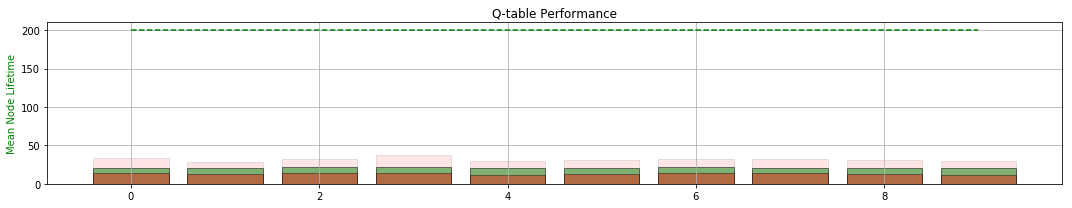

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 374.007	LOSS : 399.397	
Validating... MEAN TIME:  107.685
LOSS : 402.034	LOSS : 391.789	
Validating... MEAN TIME:  113.44
LOSS : 375.549	LOSS : 403.043	
Validating... MEAN TIME:  86.745
LOSS : 384.371	LOSS : 376.716	
Validating... MEAN TIME:  86.975
LOSS : 411.274	LOSS : 370.746	
Validating... MEAN TIME:  78.265
TRAINING TIME:0:00:23.594139


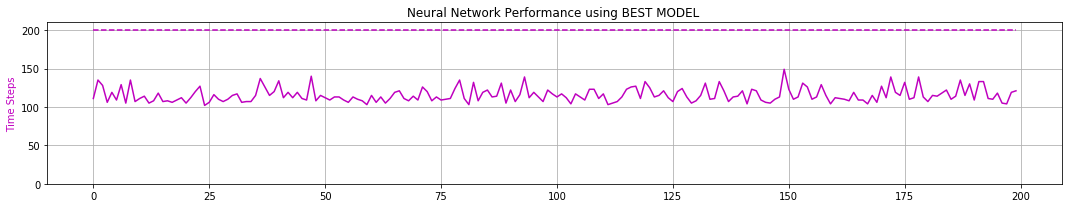

peak memory: 1439.17 MiB, increment: 1016.74 MiB
0 -max- [ 0.219  0.800  0.050  0.335]
0 -min- [-0.050 -0.588 -0.209 -1.368]

1 -max- [ 0.218  0.790  0.050  0.253]
1 -min- [-0.070 -0.760 -0.209 -1.191]

2 -max- [ 0.201  0.980  0.048  0.289]
2 -min- [-0.072 -0.755 -0.209 -1.381]

3 -max- [ 0.204  0.820  0.050  0.299]
3 -min- [-0.081 -0.774 -0.209 -1.384]

4 -max- [ 0.194  0.828  0.053  0.339]
4 -min- [-0.070 -0.761 -0.209 -1.322]

5 -max- [ 0.214  0.642  0.050  0.289]
5 -min- [-0.049 -0.590 -0.209 -1.116]

6 -max- [ 0.176  0.639  0.049  0.078]
6 -min- [-0.050 -0.746 -0.209 -1.095]

7 -max- [ 0.209  0.787  0.049  0.289]
7 -min- [-0.050 -0.715 -0.209 -1.254]

8 -max- [ 0.223  0.828  0.047  0.316]
8 -min- [-0.050 -0.590 -0.209 -1.382]

9 -max- [ 0.219  0.817  0.055  0.300]
9 -min- [-0.050 -0.595 -0.209 -1.384]

Quantization TIME:  0.02 minutes


ITERATION # 39
TOTAL EXPERIENCE GENERATED:   20586
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 67
TOTAL SERIAL TIMESTEPS:   2066886
TOTAL PARALLEL TI

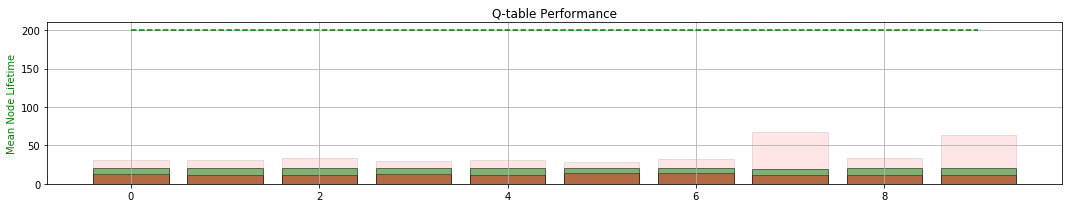

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 394.107	LOSS : 400.879	
Validating... MEAN TIME:  60.57
LOSS : 401.552	LOSS : 406.678	
Validating... MEAN TIME:  58.37
LOSS : 420.673	LOSS : 423.899	
Validating... MEAN TIME:  52.27
LOSS : 390.064	LOSS : 405.060	
Validating... MEAN TIME:  53.285
LOSS : 425.671	LOSS : 414.428	
Validating... MEAN TIME:  52.375
TRAINING TIME:0:00:17.228622


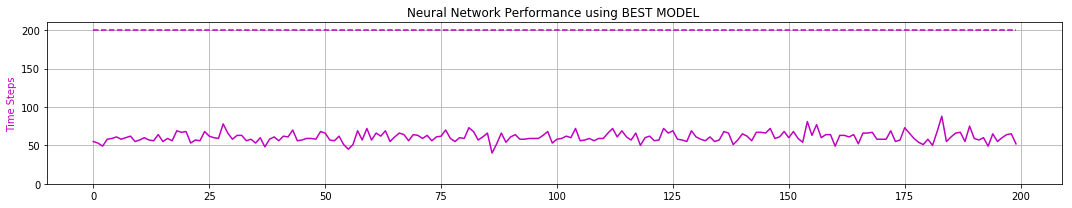

peak memory: 1439.19 MiB, increment: 977.81 MiB
0 -max- [ 0.218  0.802  0.050  0.330]
0 -min- [-0.070 -0.760 -0.209 -1.229]

1 -max- [ 0.194  0.779  0.048  0.427]
1 -min- [-0.055 -0.735 -0.209 -1.355]

2 -max- [ 0.205  0.830  0.050  0.267]
2 -min- [-0.050 -0.694 -0.209 -1.367]

3 -max- [ 0.194  0.790  0.049  0.343]
3 -min- [-0.070 -0.761 -0.209 -1.416]

4 -max- [ 0.214  0.826  0.050  0.197]
4 -min- [-0.049 -0.596 -0.209 -1.327]

5 -max- [ 0.175  0.825  0.049  0.261]
5 -min- [-0.050 -0.753 -0.209 -1.293]

6 -max- [ 0.217  0.829  0.049  0.332]
6 -min- [-0.050 -0.593 -0.209 -1.181]

7 -max- [ 0.215  0.818  0.047  0.379]
7 -min- [-1.047 -1.859 -0.209 -1.253]

8 -max- [ 0.219  0.815  0.051  0.073]
8 -min- [-0.050 -0.595 -0.209 -1.435]

9 -max- [ 0.209  0.804  0.047  0.375]
9 -min- [-0.865 -1.836 -0.209 -1.428]

Quantization TIME:  0.02 minutes


ITERATION # 40
TOTAL EXPERIENCE GENERATED:   20374
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 35
TOTAL SERIAL TIMESTEPS:   2087260
TOTAL PARALLEL TIM

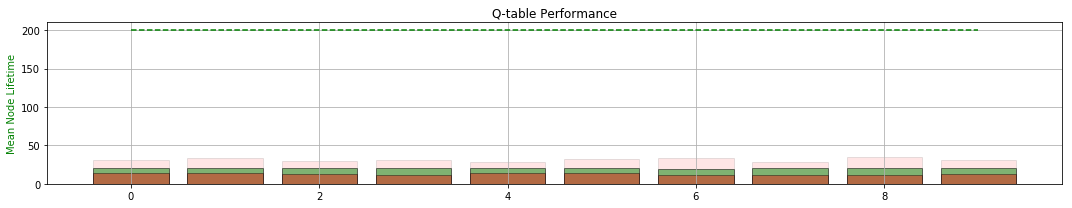

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 413.230	LOSS : 397.616	
Validating... MEAN TIME:  47.71
LOSS : 392.163	LOSS : 414.090	
Validating... MEAN TIME:  45.16
LOSS : 424.664	LOSS : 427.001	
Validating... MEAN TIME:  44.15
LOSS : 407.836	LOSS : 419.342	
Validating... MEAN TIME:  43.665
LOSS : 436.043	LOSS : 409.426	
Validating... MEAN TIME:  40.965
TRAINING TIME:0:00:15.048096


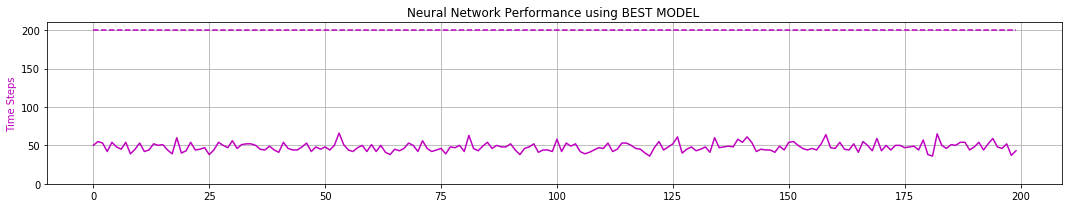

peak memory: 1439.32 MiB, increment: 1016.76 MiB
0 -max- [ 0.193  0.774  0.048  0.562]
0 -min- [-0.119 -0.778 -0.209 -1.325]

1 -max- [ 0.205  0.830  0.050  0.186]
1 -min- [-0.050 -0.694 -0.209 -1.314]

2 -max- [ 0.194  0.822  0.049  0.254]
2 -min- [-0.070 -0.761 -0.209 -1.416]

3 -max- [ 0.215  0.824  0.050  0.245]
3 -min- [-0.049 -0.593 -0.209 -1.266]

4 -max- [ 0.176  0.798  0.049  0.261]
4 -min- [-0.050 -0.753 -0.209 -1.263]

5 -max- [ 0.217  0.644  0.049  0.076]
5 -min- [-0.050 -0.593 -0.209 -1.106]

6 -max- [ 0.215  0.811  0.047  0.289]
6 -min- [-0.107 -0.781 -0.209 -1.377]

7 -max- [ 0.234  1.012  0.053  0.353]
7 -min- [-0.050 -0.592 -0.209 -1.320]

8 -max- [ 0.209  0.825  0.047  0.324]
8 -min- [-0.113 -0.759 -0.209 -1.294]

9 -max- [ 0.207  0.831  0.050  0.303]
9 -min- [-0.061 -0.770 -0.209 -1.374]

Quantization TIME:  0.01 minutes


ITERATION # 41
TOTAL EXPERIENCE GENERATED:   21145
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 35
TOTAL SERIAL TIMESTEPS:   2108405
TOTAL PARALLEL TI

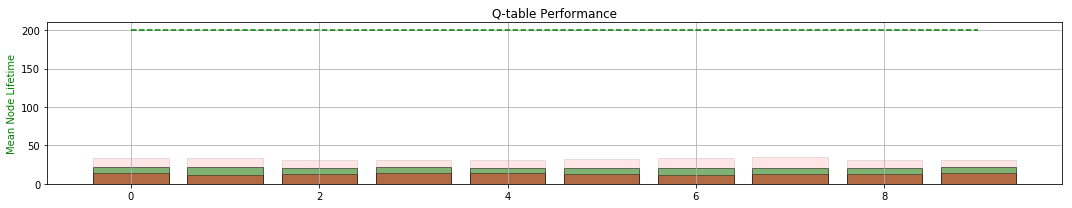

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 447.260	LOSS : 423.932	
Validating... MEAN TIME:  40.825
LOSS : 406.642	LOSS : 446.630	
Validating... MEAN TIME:  38.115
LOSS : 430.234	LOSS : 421.295	
Validating... MEAN TIME:  36.46
LOSS : 442.884	LOSS : 420.231	
Validating... MEAN TIME:  35.765
LOSS : 443.927	LOSS : 420.532	
Validating... MEAN TIME:  37.61
TRAINING TIME:0:00:13.554273


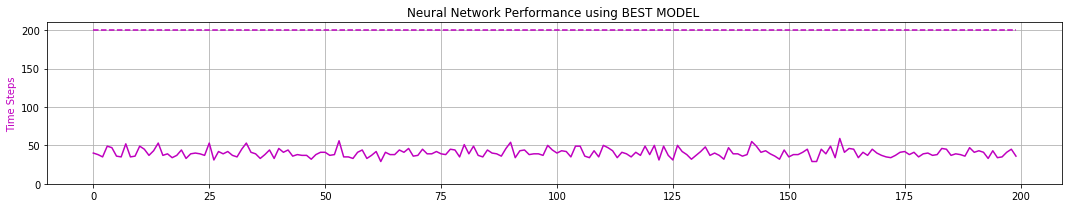

peak memory: 1482.05 MiB, increment: 1022.34 MiB
0 -max- [ 0.205  0.824  0.050  0.301]
0 -min- [-0.061 -0.595 -0.209 -1.337]

1 -max- [ 0.194  0.826  0.049  0.079]
1 -min- [-0.070 -0.768 -0.209 -1.360]

2 -max- [ 0.214  0.801  0.050  0.294]
2 -min- [-0.049 -0.690 -0.209 -1.286]

3 -max- [ 0.174  0.789  0.049  0.322]
3 -min- [-0.050 -0.749 -0.209 -1.387]

4 -max- [ 0.217  0.735  0.049  0.079]
4 -min- [-0.050 -0.593 -0.209 -1.127]

5 -max- [ 0.215  0.820  0.047  0.310]
5 -min- [-0.050 -0.725 -0.209 -1.244]

6 -max- [ 0.219  0.803  0.051  0.296]
6 -min- [-0.050 -0.594 -0.209 -1.384]

7 -max- [ 0.209  0.829  0.047  0.301]
7 -min- [-0.113 -0.759 -0.209 -1.237]

8 -max- [ 0.207  0.829  0.050  0.336]
8 -min- [-0.061 -0.770 -0.209 -1.397]

9 -max- [ 0.190  0.786  0.050  0.326]
9 -min- [-0.073 -0.754 -0.209 -1.175]

Quantization TIME:  0.02 minutes


ITERATION # 42
TOTAL EXPERIENCE GENERATED:   20902
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 33
TOTAL SERIAL TIMESTEPS:   2129307
TOTAL PARALLEL TI

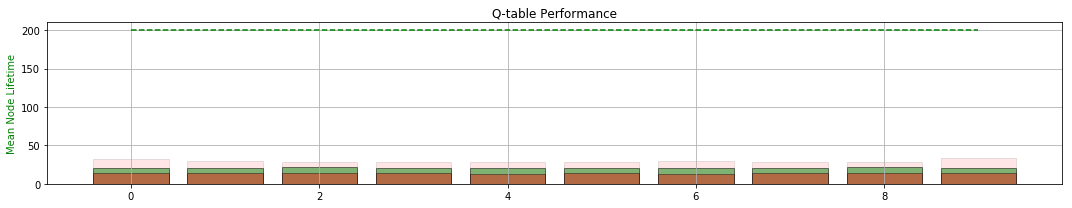

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 407.697	LOSS : 414.103	
Validating... MEAN TIME:  37.61
LOSS : 417.181	LOSS : 422.510	
Validating... MEAN TIME:  37.995
LOSS : 424.287	LOSS : 398.809	
Validating... MEAN TIME:  38.145
LOSS : 422.379	LOSS : 419.108	
Validating... MEAN TIME:  38.585
LOSS : 413.575	LOSS : 421.661	
Validating... MEAN TIME:  39.525
TRAINING TIME:0:00:13.602116


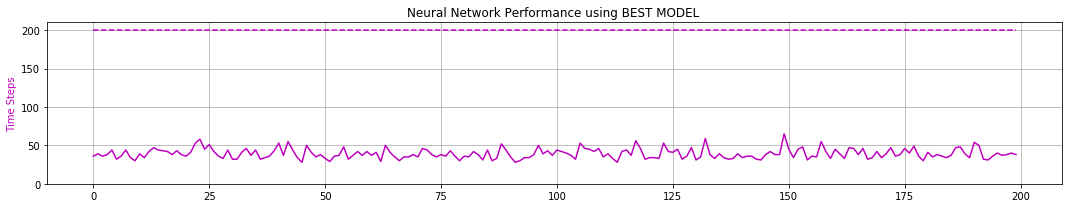

peak memory: 1490.51 MiB, increment: 1030.54 MiB
0 -max- [ 0.194  0.822  0.054  0.302]
0 -min- [-0.050 -0.536 -0.209 -1.423]

1 -max- [ 0.214  0.821  0.050  0.063]
1 -min- [-0.049 -0.558 -0.209 -1.221]

2 -max- [ 0.185  0.832  0.049  0.253]
2 -min- [-0.050 -0.575 -0.209 -1.328]

3 -max- [ 0.217  0.643  0.049  0.332]
3 -min- [-0.050 -0.557 -0.209 -1.106]

4 -max- [ 0.223  0.832  0.047  0.264]
4 -min- [-0.050 -0.558 -0.209 -1.427]

5 -max- [ 0.217  0.986  0.051  0.292]
5 -min- [-0.052 -0.413 -0.209 -1.566]

6 -max- [ 0.209  0.834  0.047  0.340]
6 -min- [-0.049 -0.542 -0.209 -1.351]

7 -max- [ 0.207  0.780  0.050  0.059]
7 -min- [-0.050 -0.528 -0.209 -1.332]

8 -max- [ 0.195  0.762  0.050  0.049]
8 -min- [-0.050 -0.563 -0.209 -1.175]

9 -max- [ 0.198  0.778  0.052  0.325]
9 -min- [-0.049 -0.580 -0.209 -1.179]

Quantization TIME:  0.02 minutes


ITERATION # 43
TOTAL EXPERIENCE GENERATED:   23123
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 33
TOTAL SERIAL TIMESTEPS:   2152430
TOTAL PARALLEL TI

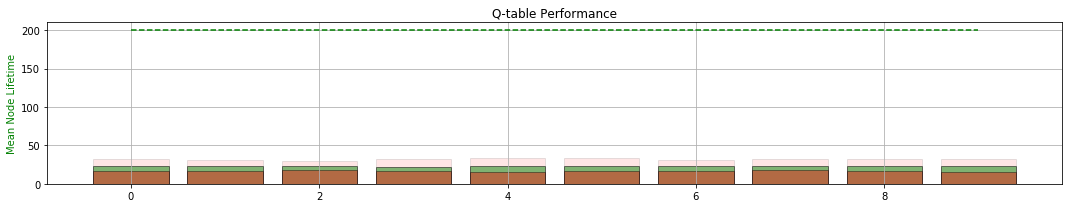

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 425.924	LOSS : 420.354	
Validating... MEAN TIME:  40.99
LOSS : 419.492	LOSS : 385.804	
Validating... MEAN TIME:  44.005
LOSS : 409.814	LOSS : 412.386	
Validating... MEAN TIME:  45.025
LOSS : 415.623	LOSS : 395.144	
Validating... MEAN TIME:  46.56
LOSS : 408.639	LOSS : 407.257	
Validating... MEAN TIME:  47.005
TRAINING TIME:0:00:15.214282


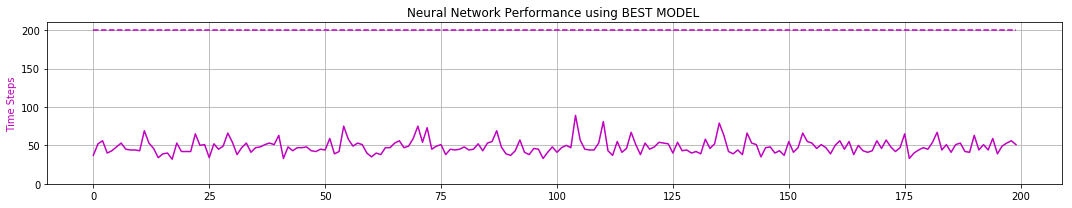

peak memory: 1439.20 MiB, increment: 1036.05 MiB
0 -max- [ 0.202  0.791  0.050  0.310]
0 -min- [-0.049 -0.326 -0.209 -1.213]

1 -max- [ 0.170  0.633  0.049  0.284]
1 -min- [-0.050 -0.320 -0.209 -1.105]

2 -max- [ 0.210  0.780  0.049  0.270]
2 -min- [-0.050 -0.320 -0.209 -1.075]

3 -max- [ 0.204  0.785  0.047  0.293]
3 -min- [-0.054 -0.343 -0.209 -1.197]

4 -max- [ 0.213  0.836  0.051  0.292]
4 -min- [-0.052 -0.320 -0.209 -1.341]

5 -max- [ 0.197  0.790  0.047  0.326]
5 -min- [-0.049 -0.398 -0.209 -1.217]

6 -max- [ 0.197  0.818  0.050  0.211]
6 -min- [-0.050 -0.504 -0.209 -1.353]

7 -max- [ 0.180  0.639  0.050  0.292]
7 -min- [-0.050 -0.318 -0.209 -1.030]

8 -max- [ 0.189  0.811  0.050  0.259]
8 -min- [-0.049 -0.389 -0.209 -1.168]

9 -max- [ 0.214  0.637  0.049  0.246]
9 -min- [-0.050 -0.405 -0.209 -1.111]

Quantization TIME:  0.02 minutes


ITERATION # 44
TOTAL EXPERIENCE GENERATED:   25491
SMALLEST TIMESTEP: 16
LARGEST  TIMESTEP: 39
TOTAL SERIAL TIMESTEPS:   2177921
TOTAL PARALLEL TI

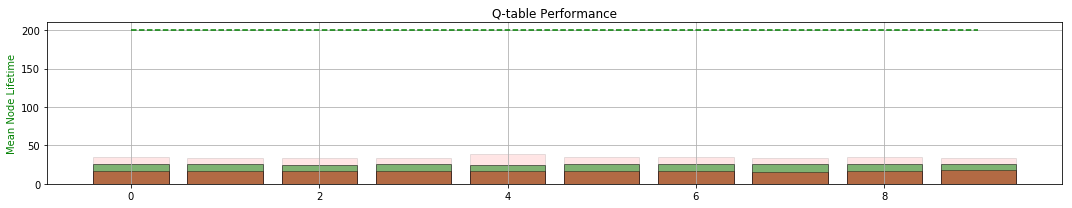

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 382.326	LOSS : 360.032	
Validating... MEAN TIME:  55.785
LOSS : 398.212	LOSS : 389.643	
Validating... MEAN TIME:  62.545
LOSS : 382.604	LOSS : 404.271	
Validating... MEAN TIME:  66.525
LOSS : 391.580	LOSS : 388.445	
Validating... MEAN TIME:  74.955
LOSS : 390.671	LOSS : 382.819	
Validating... MEAN TIME:  77.795
TRAINING TIME:0:00:19.262626


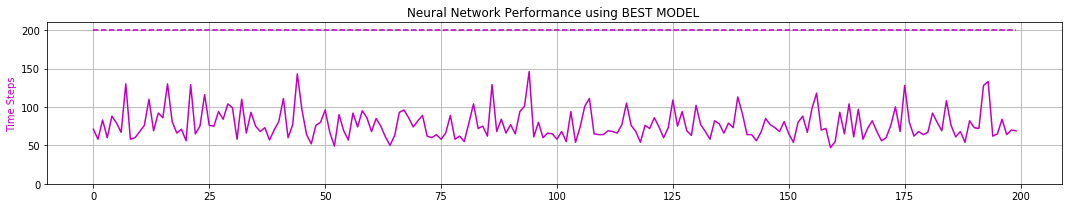

peak memory: 1477.43 MiB, increment: 1015.69 MiB
0 -max- [ 0.157  0.631  0.049  0.334]
0 -min- [-0.058 -0.576 -0.209 -0.920]

1 -max- [ 0.210  0.780  0.049  0.271]
1 -min- [-0.069 -0.576 -0.209 -1.065]

2 -max- [ 0.209  0.633  0.050  0.297]
2 -min- [-0.053 -0.758 -0.209 -1.141]

3 -max- [ 0.212  0.818  0.051  0.318]
3 -min- [-0.059 -0.581 -0.209 -1.138]

4 -max- [ 0.195  0.628  0.047  0.329]
4 -min- [-0.060 -0.574 -0.209 -1.079]

5 -max- [ 0.193  0.630  0.050  0.302]
5 -min- [-0.060 -0.576 -0.209 -0.994]

6 -max- [ 0.174  0.634  0.058  0.350]
6 -min- [-0.078 -0.570 -0.209 -0.974]

7 -max- [ 0.187  0.764  0.050  0.264]
7 -min- [-0.059 -0.756 -0.209 -1.116]

8 -max- [ 0.207  0.634  0.049  0.321]
8 -min- [-0.061 -0.571 -0.209 -0.964]

9 -max- [ 0.208  0.636  0.050  0.339]
9 -min- [-0.071 -0.575 -0.209 -1.062]

Quantization TIME:  0.02 minutes


ITERATION # 45
TOTAL EXPERIENCE GENERATED:   28591
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 44
TOTAL SERIAL TIMESTEPS:   2206512
TOTAL PARALLEL TI

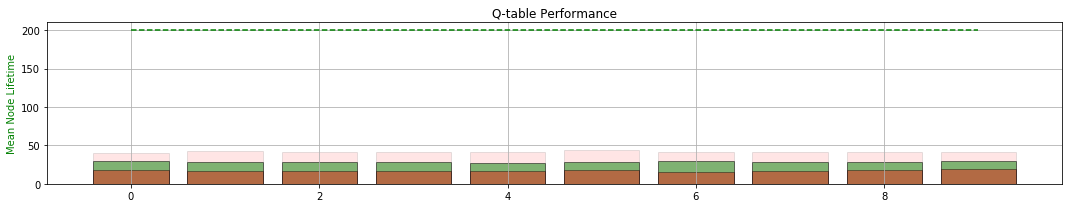

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 388.567	LOSS : 396.486	
Validating... MEAN TIME:  111.52
LOSS : 388.122	LOSS : 377.133	
Validating... MEAN TIME:  122.385
LOSS : 395.117	LOSS : 388.802	
Validating... MEAN TIME:  129.765
LOSS : 387.215	LOSS : 373.646	
Validating... MEAN TIME:  133.85
LOSS : 391.605	LOSS : 380.399	
Validating... MEAN TIME:  135.405
TRAINING TIME:0:00:30.004883


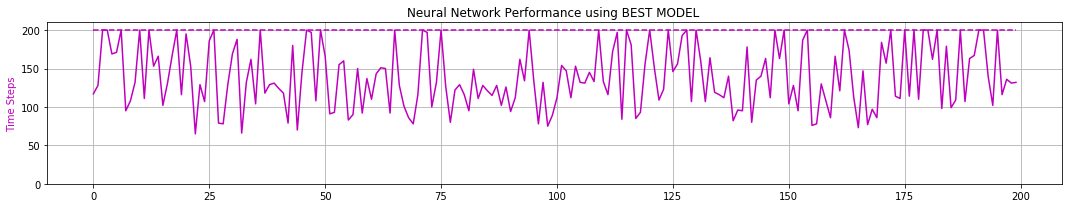

peak memory: 1439.33 MiB, increment: 1016.41 MiB
0 -max- [ 0.196  0.563  0.049  0.325]
0 -min- [-0.213 -0.931 -0.209 -0.891]

1 -max- [ 0.212  0.638  0.047  0.332]
1 -min- [-0.197 -0.935 -0.209 -1.110]

2 -max- [ 0.212  0.630  0.051  0.348]
2 -min- [-0.207 -0.931 -0.209 -1.253]

3 -max- [ 0.196  0.588  0.047  0.278]
3 -min- [-0.196 -0.900 -0.209 -0.913]

4 -max- [ 0.187  0.635  0.050  0.220]
4 -min- [-0.218 -0.927 -0.209 -1.113]

5 -max- [ 0.173  0.631  0.052  0.320]
5 -min- [-0.150 -0.761 -0.209 -1.139]

6 -max- [ 0.183  0.840  0.050  0.336]
6 -min- [-0.204 -0.915 -0.209 -1.420]

7 -max- [ 0.212  0.632  0.049  0.296]
7 -min- [-0.198 -0.881 -0.209 -1.081]

8 -max- [ 0.207  0.635  0.050  0.323]
8 -min- [-0.171 -0.911 -0.209 -1.096]

9 -max- [ 0.191  0.793  0.050  0.337]
9 -min- [-0.206 -0.931 -0.209 -1.382]

Quantization TIME:  0.02 minutes


ITERATION # 46
TOTAL EXPERIENCE GENERATED:   111315
SMALLEST TIMESTEP: 25
LARGEST  TIMESTEP: 169
TOTAL SERIAL TIMESTEPS:   2317827
TOTAL PARALLEL 

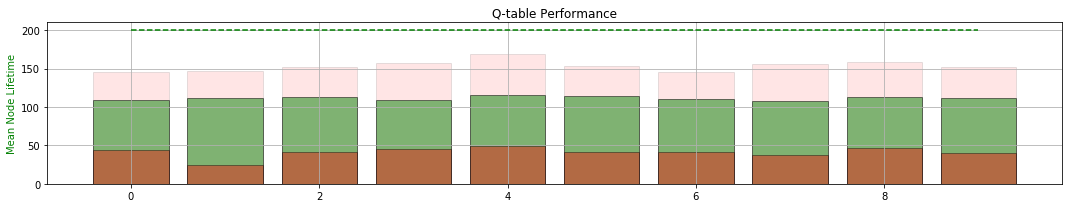

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 623.099	LOSS : 792.618	
Validating... MEAN TIME:  144.835
LOSS : 886.559	LOSS : 904.552	
Validating... MEAN TIME:  116.485
LOSS : 916.119	LOSS : 895.905	
Validating... MEAN TIME:  63.475
LOSS : 883.743	LOSS : 860.707	
Validating... MEAN TIME:  36.4
LOSS : 838.768	LOSS : 803.446	
Validating... MEAN TIME:  27.015
TRAINING TIME:0:00:21.306466


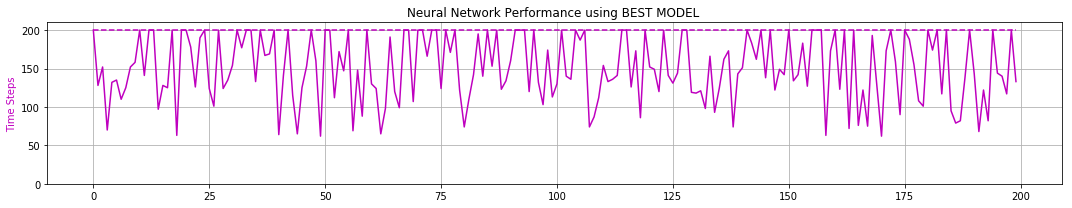

peak memory: 1441.44 MiB, increment: 981.57 MiB
0 -max- [ 0.244  0.806  0.209  0.929]
0 -min- [-2.400 -2.379 -0.209 -1.061]

1 -max- [ 0.226  0.799  0.209  0.947]
1 -min- [-2.399 -2.384 -0.209 -1.021]

2 -max- [ 0.196  0.612  0.209  0.947]
2 -min- [-2.400 -2.397 -0.209 -0.775]

3 -max- [ 0.221  0.628  0.207  0.931]
3 -min- [-2.400 -2.427 -0.209 -0.967]

4 -max- [ 0.197  0.801  0.209  1.002]
4 -min- [-2.400 -2.414 -0.209 -1.337]

5 -max- [ 0.228  0.630  0.209  0.912]
5 -min- [-2.398 -2.406 -0.209 -1.005]

6 -max- [ 0.244  0.638  0.208  0.966]
6 -min- [-2.398 -2.410 -0.209 -0.936]

7 -max- [ 0.251  0.629  0.209  0.920]
7 -min- [-2.400 -2.421 -0.209 -1.073]

8 -max- [ 0.217  0.613  0.208  0.886]
8 -min- [-2.400 -2.236 -0.209 -0.780]

9 -max- [ 0.254  0.622  0.209  0.909]
9 -min- [-2.400 -2.374 -0.209 -1.028]

Quantization TIME:  0.02 minutes


ITERATION # 47
TOTAL EXPERIENCE GENERATED:   79854
SMALLEST TIMESTEP: 40
LARGEST  TIMESTEP: 125
TOTAL SERIAL TIMESTEPS:   2397681
TOTAL PARALLEL TI

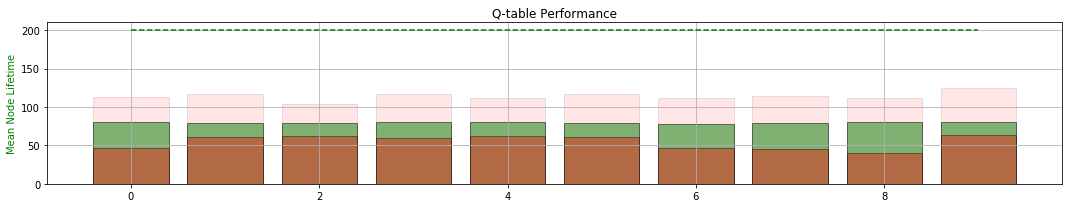

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 708.521	LOSS : 670.822	
Validating... MEAN TIME:  23.73
LOSS : 644.490	LOSS : 601.699	
Validating... MEAN TIME:  22.26
LOSS : 587.004	LOSS : 535.076	
Validating... MEAN TIME:  20.925
LOSS : 502.270	LOSS : 475.467	
Validating... MEAN TIME:  20.415
LOSS : 451.679	LOSS : 428.322	
Validating... MEAN TIME:  21.12
TRAINING TIME:0:00:11.035366


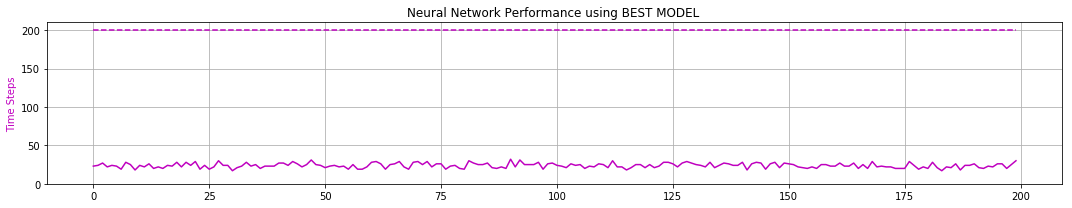

peak memory: 1480.89 MiB, increment: 977.61 MiB
0 -max- [ 0.238  0.627  0.209  1.349]
0 -min- [-0.936 -1.896 -0.203 -0.774]

1 -max- [ 0.194  0.639  0.209  1.360]
1 -min- [-0.896 -1.900 -0.188 -0.936]

2 -max- [ 0.206  0.628  0.209  1.419]
2 -min- [-0.917 -1.899 -0.188 -1.075]

3 -max- [ 0.200  0.627  0.209  1.354]
3 -min- [-0.908 -1.899 -0.192 -0.969]

4 -max- [ 0.200  0.630  0.209  1.639]
4 -min- [-0.918 -2.101 -0.192 -0.987]

5 -max- [ 0.236  0.642  0.209  1.571]
5 -min- [-0.867 -2.203 -0.209 -1.029]

6 -max- [ 0.236  0.635  0.209  1.433]
6 -min- [-0.906 -2.024 -0.203 -1.111]

7 -max- [ 0.219  0.756  0.209  1.380]
7 -min- [-0.904 -1.902 -0.206 -0.968]

8 -max- [ 0.254  0.619  0.209  1.588]
8 -min- [-0.900 -2.075 -0.202 -0.811]

9 -max- [ 0.185  0.620  0.209  1.386]
9 -min- [-0.886 -1.896 -0.186 -0.780]

Quantization TIME:  0.02 minutes


ITERATION # 48
TOTAL EXPERIENCE GENERATED:   47448
SMALLEST TIMESTEP: 23
LARGEST  TIMESTEP: 98
TOTAL SERIAL TIMESTEPS:   2445129
TOTAL PARALLEL TIM

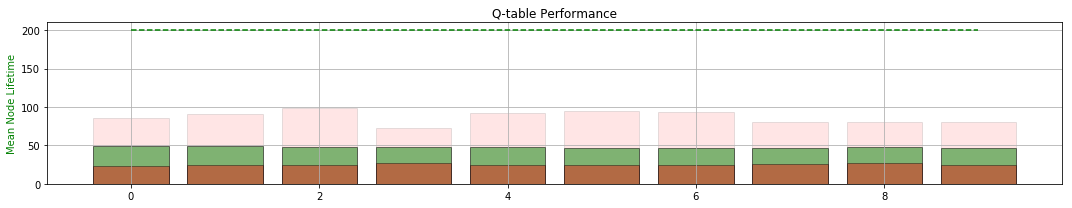

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 364.716	LOSS : 354.697	
Validating... MEAN TIME:  26.1
LOSS : 323.980	LOSS : 275.456	
Validating... MEAN TIME:  35.97
LOSS : 283.799	LOSS : 256.975	
Validating... MEAN TIME:  76.13
LOSS : 247.258	LOSS : 242.139	
Validating... MEAN TIME:  117.395
LOSS : 223.872	LOSS : 197.326	
Validating... MEAN TIME:  143.73
TRAINING TIME:0:00:21.045930


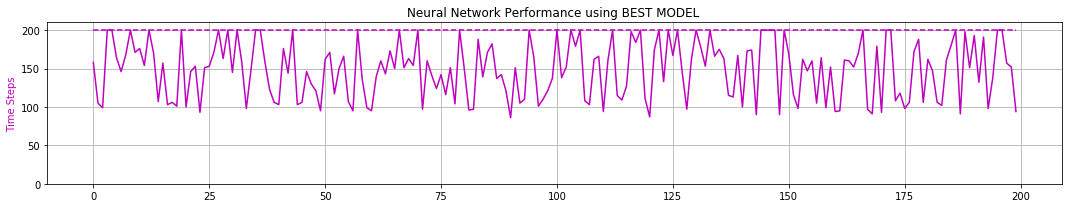

peak memory: 1472.00 MiB, increment: 1072.61 MiB
0 -max- [ 0.466  1.331  0.209  1.005]
0 -min- [-0.255 -0.632 -0.050 -0.422]

1 -max- [ 0.350  1.120  0.209  0.929]
1 -min- [-0.258 -0.625 -0.050 -0.424]

2 -max- [ 2.384  3.018  0.209  0.990]
2 -min- [-0.242 -0.730 -0.201 -1.354]

3 -max- [ 0.326  1.114  0.209  1.121]
3 -min- [-0.217 -0.626 -0.050 -0.598]

4 -max- [ 0.618  1.509  0.209  1.165]
4 -min- [-0.231 -0.817 -0.050 -0.424]

5 -max- [ 0.346  1.081  0.209  1.071]
5 -min- [-0.230 -0.639 -0.049 -0.393]

6 -max- [ 0.334  1.137  0.209  1.054]
6 -min- [-0.227 -0.628 -0.050 -0.548]

7 -max- [ 0.346  1.132  0.209  1.061]
7 -min- [-0.242 -0.622 -0.048 -0.388]

8 -max- [ 0.456  1.321  0.209  1.040]
8 -min- [-0.204 -0.602 -0.048 -0.404]

9 -max- [ 0.402  1.259  0.209  1.086]
9 -min- [-0.224 -0.630 -0.054 -0.557]

Quantization TIME:  0.02 minutes


ITERATION # 49
TOTAL EXPERIENCE GENERATED:   75349
SMALLEST TIMESTEP: 42
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   2520478
TOTAL PARALLEL T

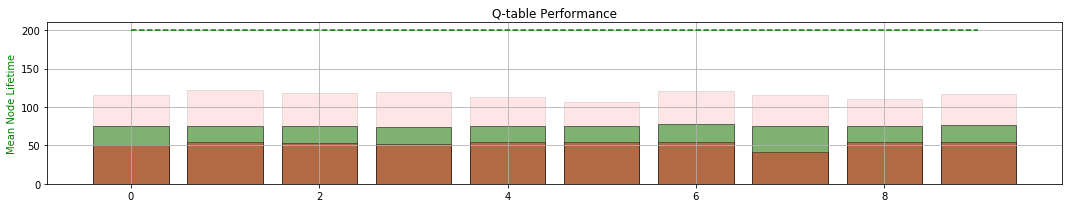

MEMORY COUNTER:  200000
Training Neural Network for 5000 iterations @ LR =  0.0001
LOSS : 200.944	LOSS : 197.796	
Validating... MEAN TIME:  148.305
LOSS : 195.889	LOSS : 195.536	
Validating... MEAN TIME:  137.385
LOSS : 196.722	LOSS : 176.872	
Validating... MEAN TIME:  109.1
LOSS : 175.774	LOSS : 165.764	
Validating... MEAN TIME:  90.215
LOSS : 181.010	LOSS : 177.516	
Validating... MEAN TIME:  86.395
TRAINING TIME:0:00:28.073144


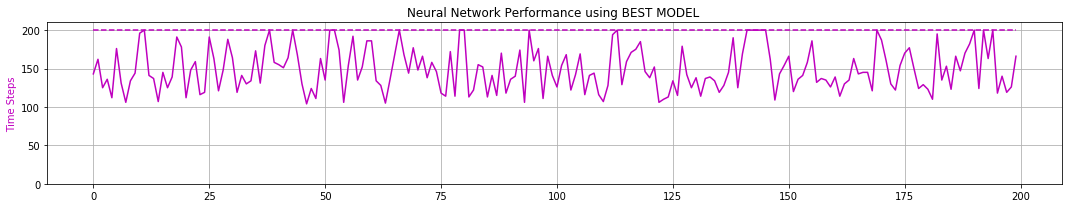

peak memory: 1434.38 MiB, increment: 977.88 MiB
0 -max- [ 0.185  0.621  0.209  1.723]
0 -min- [-0.713 -2.081 -0.179 -0.881]

1 -max- [ 0.169  0.628  0.209  1.739]
1 -min- [-0.776 -2.256 -0.208 -0.908]

2 -max- [ 0.209  0.763  0.209  1.718]
2 -min- [-0.700 -2.076 -0.167 -1.217]

3 -max- [ 0.208  0.628  0.209  1.706]
3 -min- [-0.751 -2.052 -0.172 -0.901]

4 -max- [ 0.204  0.615  0.209  1.725]
4 -min- [-0.731 -2.078 -0.168 -0.751]

5 -max- [ 0.187  0.610  0.209  1.700]
5 -min- [-0.716 -2.218 -0.189 -0.768]

6 -max- [ 0.241  0.617  0.209  1.719]
6 -min- [-0.728 -2.226 -0.184 -0.776]

7 -max- [ 0.187  0.935  0.209  1.747]
7 -min- [-0.740 -2.090 -0.209 -1.368]

8 -max- [ 0.175  0.615  0.209  1.917]
8 -min- [-0.766 -2.251 -0.175 -0.775]

9 -max- [ 0.192  0.626  0.209  1.689]
9 -min- [-0.732 -2.041 -0.168 -0.741]

Quantization TIME:  0.02 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5571.0
Total Serial Timesteps   :  2520478.0
Speed-up                 :  452.43


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 FAILURE  42  50    5571    2520478     452.43
